In [4]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

import ants
from nipype.interfaces import afni

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

import re
# networks
import networkx as nx
from sklearn.covariance import GraphicalLassoCV

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [5]:
class ARGS():
    pass

args = ARGS()

In [6]:
args.parcel_name = 'whole'
BASE_path = f'/home/saba/mice/data/roi/govinda_cortex'
TS_path = f'{BASE_path}/roi_timeseries_txt_files/{args.parcel_name}'
FC_path = f'{BASE_path}/fun_files/'
FC_percentile_path = f'{BASE_path}/fun_percentile_files/concat'
PARCELS_path = f'/home/saba/mice/data/allen_atlas_ccfv3/govinda_parcellation'

In [7]:

args.num_subs = 10
args.num_sess = 3
args.num_rois = len(np.loadtxt(
        (
            f'/home/saba/mice/data/allen_atlas_ccfv3/govinda_parcellation/type-spatial_size-112_symm-True_braindiv-ctx_nrois-100_desc-labels.txt'
        )
    ).astype(int)
)
args.percentile = 90

In [8]:
args.num_rois

100

In [9]:
parcels_img = ants.image_read(f'{PARCELS_path}/type-spatial_size-112_symm-True_braindiv-ctx_nrois-100_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/type-spatial_size-112_symm-True_braindiv-ctx_nrois-100_desc-labels.txt')
dynamic_nws_path = f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws'
COLLECT_path = f'/home/saba/mice/data/voxel/all_file_collections'

In [10]:
args.percentile = 90
main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    if sub == 2 and ses ==2:
        continue
    else:
        # run = int(fs[2].split('-')[-1])
        main_sample[sub-1][ses-1].append(file)
for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [11]:
subject_data = {}

for subj in range(len(main_sample)):
    subj_key = f"subj{subj+1:02d}"
    subject_data[subj_key] = []

    for ses in range(len(main_sample[subj])):
        for run in range(len(main_sample[subj][ses])):
            ts_path = main_sample[subj][ses][run]
            ts = np.loadtxt(f'{TS_path}/{ts_path}')
            #row_means = np.nanmean(ts, axis=0, keepdims=True)
            #demeaned_matrix = ts - row_means
            subject_data[subj_key].append(ts)
concatenated_data = {key: np.concatenate(value, axis=0) for key, value in subject_data.items()}

In [12]:
all_subjects_data = np.concatenate(list(concatenated_data.values()), axis=0)

In [13]:
concatenated_data=all_subjects_data 

In [14]:
csv_file_path = f"{PARCELS_path}/type-spatial_size-112_symm-True_braindiv-ctx_nrois-100_desc-names.csv"
govinda_anno = pd.read_csv(csv_file_path, header=None, sep='\t')

In [15]:
govinda_anno 

0                                                  1
0     1  L-Primary somatosensory area, upper limb (SSp-...
1     2             L-Temporal association areas (TEa,627)
2     3                   L-Primary visual area (VISp,471)
3     4                         L-Prelimbic area (PL,1058)
4     5        L-Supplemental somatosensory area (SSs,464)
..  ...                                                ...
95   96                   R-Secondary motor area (MOs,993)
96   97      R-Retrosplenial area, ventral part (RSPv,886)
97   98    R-Primary somatosensory area, mouth (SSp-m,345)
98   99                    R-Hippocampal region (HIP,1080)
99  100       R-Retrosplenial area, dorsal part (RSPd,879)

[100 rows x 2 columns]

In [16]:

for row in range (len(govinda_anno)):
    input_string = f"{govinda_anno.iloc[row][1]}"
  
    match = re.search(r'\((.*?)\)', input_string)
    acro_names = match.group(1).split(",")[0]
    govinda_anno.at[row, 'acro'] = f"{acro_names}"
    govinda_anno.at[row, 'hemis'] = f"{input_string[0]}"


In [17]:
govinda_anno.head()

0                                                  1    acro hemis
0  1  L-Primary somatosensory area, upper limb (SSp-...  SSp-ul     L
1  2             L-Temporal association areas (TEa,627)     TEa     L
2  3                   L-Primary visual area (VISp,471)    VISp     L
3  4                         L-Prelimbic area (PL,1058)      PL     L
4  5        L-Supplemental somatosensory area (SSs,464)     SSs     L

In [18]:
acro_list=[]
for row in range (len(govinda_anno)):
    acro_list.append(govinda_anno.iloc[row]['acro'])

In [19]:
print(len(np.unique(acro_list)))

25


In [20]:
print((np.unique(acro_list)))

['ACAv' 'AId' 'AUDp' 'GU' 'HIP' 'MOp' 'MOs' 'ORBl' 'ORBvl' 'PL' 'RSPd'
 'RSPv' 'SSp-bfd' 'SSp-ll' 'SSp-m' 'SSp-n' 'SSp-ul' 'SSs' 'TEa' 'VISC'
 'VISa' 'VISam' 'VISp' 'VISpor' 'VISrl']


In [21]:
VIS=['VISa','VISam','VISp','VISpor','VISrl']
VISC = ['VISC']
TEa =['TEa']
SS = ['SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-ul', 'SSs']
RSP=['RSPv','RSPd' ]
PL=['PL']
ORB = ['ORBl', 'ORBvl']
MO = ['MOp', 'MOs']
HIP =['HIP']
GU=['GU']
AUD =['AUDp']
AI = ['AId']
ACA = ['ACAv']

sort_acro =[MO,VIS,AUD,TEa,SS,GU,PL,ACA,VISC,AI,HIP,RSP,ORB]
brain_regions = {
    'MO': MO,
    'VIS': VIS,
    'AUD': AUD,
    'TEa': TEa,
    'SS': SS,
    'GU': GU,
    'PL': PL,
    'ACA': ACA,
    'VISC': VISC,
    'AI': AI,
    'HIP': HIP,
    'RSP': RSP,
    'ORB': ORB
}


In [22]:
acro_map = {}
count = 0

for sort_num, acronyms in enumerate(sort_acro, start=1):
    for acronym in acronyms:
        count += 1
        acro_map[acronym] = {'L': str(count), 'R': str(count + 1)}
        count += 1

print(acro_map)
 

{'MOp': {'L': '1', 'R': '2'}, 'MOs': {'L': '3', 'R': '4'}, 'VISa': {'L': '5', 'R': '6'}, 'VISam': {'L': '7', 'R': '8'}, 'VISp': {'L': '9', 'R': '10'}, 'VISpor': {'L': '11', 'R': '12'}, 'VISrl': {'L': '13', 'R': '14'}, 'AUDp': {'L': '15', 'R': '16'}, 'TEa': {'L': '17', 'R': '18'}, 'SSp-bfd': {'L': '19', 'R': '20'}, 'SSp-ll': {'L': '21', 'R': '22'}, 'SSp-m': {'L': '23', 'R': '24'}, 'SSp-n': {'L': '25', 'R': '26'}, 'SSp-ul': {'L': '27', 'R': '28'}, 'SSs': {'L': '29', 'R': '30'}, 'GU': {'L': '31', 'R': '32'}, 'PL': {'L': '33', 'R': '34'}, 'ACAv': {'L': '35', 'R': '36'}, 'VISC': {'L': '37', 'R': '38'}, 'AId': {'L': '39', 'R': '40'}, 'HIP': {'L': '41', 'R': '42'}, 'RSPv': {'L': '43', 'R': '44'}, 'RSPd': {'L': '45', 'R': '46'}, 'ORBl': {'L': '47', 'R': '48'}, 'ORBvl': {'L': '49', 'R': '50'}}


In [23]:
for row in range(len(govinda_anno)):
    current_acro = govinda_anno.iloc[row]['acro']
    current_hemis = govinda_anno.iloc[row]['hemis']
    if current_acro in acro_map:
        if current_hemis == 'L':
            govinda_anno.at[row, 'sort_acro'] = acro_map[current_acro]['L']
        if current_hemis == 'R':
            govinda_anno.at[row, 'sort_acro'] = acro_map[current_acro]['R']

In [24]:
govinda_anno.iloc[:, 0] -= 1
govinda_anno


0                                                  1    acro hemis  \
0    0  L-Primary somatosensory area, upper limb (SSp-...  SSp-ul     L   
1    1             L-Temporal association areas (TEa,627)     TEa     L   
2    2                   L-Primary visual area (VISp,471)    VISp     L   
3    3                         L-Prelimbic area (PL,1058)      PL     L   
4    4        L-Supplemental somatosensory area (SSs,464)     SSs     L   
..  ..                                                ...     ...   ...   
95  95                   R-Secondary motor area (MOs,993)     MOs     R   
96  96      R-Retrosplenial area, ventral part (RSPv,886)    RSPv     R   
97  97    R-Primary somatosensory area, mouth (SSp-m,345)   SSp-m     R   
98  98                    R-Hippocampal region (HIP,1080)     HIP     R   
99  99       R-Retrosplenial area, dorsal part (RSPd,879)    RSPd     R   

   sort_acro  
0         27  
1         17  
2          9  
3         33  
4         29  
..       ...  
95         4  
96        44  
97        24  
98        42  
99        46  

[100 rows x 5 columns]

In [25]:
indices_with_values = {}

for i in range(1, 51):
    indices_with_values[i] = []

for index, row in govinda_anno.iterrows():
    sort_acro_value = int(row['sort_acro'])
    if 1 <= sort_acro_value <= 50:
        indices_with_values[sort_acro_value].append(index)





In [26]:
info_anno_fc=[]
info_anno_coarse_fc = {}
for value, indices in indices_with_values.items():
    location = np.where(govinda_anno['sort_acro'] == f'{value}')[0]
    corresponding_acro = govinda_anno['acro'].iloc[location[0]]
    corresponding_hemis = govinda_anno['hemis'].iloc[location[0]]
    info_anno_fc.append([f'{corresponding_acro}_{corresponding_hemis}',len(location)])
    for key, regions in brain_regions.items():
        if corresponding_acro in regions:
            # Update the length of the brain region
            info_anno_coarse_fc.setdefault(key, 0)
            info_anno_coarse_fc[key] += len(location)

In [27]:
info_anno_coarse_fc

{'MO': 20,
 'VIS': 16,
 'AUD': 2,
 'TEa': 4,
 'SS': 26,
 'GU': 2,
 'PL': 4,
 'ACA': 6,
 'VISC': 2,
 'AI': 4,
 'HIP': 2,
 'RSP': 8,
 'ORB': 4}

In [28]:
govinda_anno.to_csv(f"{PARCELS_path}/sorted_anno.csv",index=False)

In [29]:
print(indices_with_values)

{1: [5, 7, 16, 25], 2: [55, 57, 66, 75], 3: [13, 18, 33, 39, 44, 45], 4: [63, 68, 83, 89, 94, 95], 5: [30], 6: [80], 7: [38], 8: [88], 9: [2, 6, 11, 24], 10: [52, 56, 61, 74], 11: [29], 12: [79], 13: [26], 14: [76], 15: [28], 16: [78], 17: [1, 22], 18: [51, 72], 19: [43], 20: [93], 21: [19], 22: [69], 23: [10, 47], 24: [60, 97], 25: [32, 42], 26: [82, 92], 27: [0, 12, 31], 28: [50, 62, 81], 29: [4, 9, 17, 23], 30: [54, 59, 67, 73], 31: [20], 32: [70], 33: [3, 41], 34: [53, 91], 35: [8, 21, 36], 36: [58, 71, 86], 37: [34], 38: [84], 39: [35, 40], 40: [85, 90], 41: [48], 42: [98], 43: [37, 46], 44: [87, 96], 45: [15, 49], 46: [65, 99], 47: [14], 48: [64], 49: [27], 50: [77]}


In [30]:
roi_list =[]

for index,values in enumerate(indices_with_values.items()):
    key, value = values
    for i in range (len(indices_with_values[key])):
        roi_list.append(indices_with_values[key][i])
print(roi_list)


[5, 7, 16, 25, 55, 57, 66, 75, 13, 18, 33, 39, 44, 45, 63, 68, 83, 89, 94, 95, 30, 80, 38, 88, 2, 6, 11, 24, 52, 56, 61, 74, 29, 79, 26, 76, 28, 78, 1, 22, 51, 72, 43, 93, 19, 69, 10, 47, 60, 97, 32, 42, 82, 92, 0, 12, 31, 50, 62, 81, 4, 9, 17, 23, 54, 59, 67, 73, 20, 70, 3, 41, 53, 91, 8, 21, 36, 58, 71, 86, 34, 84, 35, 40, 85, 90, 48, 98, 37, 46, 87, 96, 15, 49, 65, 99, 14, 64, 27, 77]


In [31]:
concatenated_data_z= stats.zscore(concatenated_data, axis=0, nan_policy='omit')
fc_static = np.corrcoef(concatenated_data_z, rowvar=False)

In [32]:
def sorting_fc (fc_static):

    fc = np.zeros_like((fc_static))
    for row_roi in range (len(fc_static)):
        for col_roi in range (len(fc_static)):
            row_sort = roi_list[row_roi]
            col_sort = roi_list [col_roi]
            fc [row_roi, col_roi] = fc_static [row_sort,col_sort]
    return fc
fc_static_sorted = sorting_fc(fc_static)

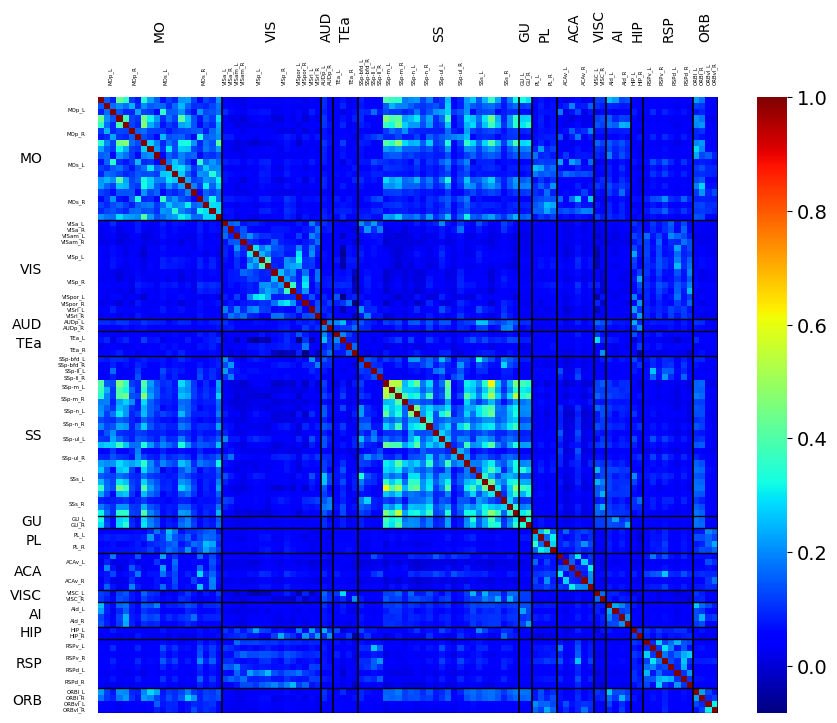

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(fc_static_sorted, cmap='jet', fmt=".2f", cbar=True)

count = 0
for acro, length in info_anno_fc:
    count += length
    plt.text(-2, count - length / 2, acro, ha='right', va='center', fontsize=4)
    plt.text(count - length / 2, -2, acro, ha='center', va='bottom', fontsize=4, rotation=90)
count2 =0
for acro_c, length_c in info_anno_coarse_fc.items():
    count2 += length_c
    plt.text(-9, count2 - length_c / 2, acro_c, ha='right', va='center', fontsize=10)
    plt.text(count2 - length_c / 2, -9, acro_c, ha='center', va='bottom', fontsize=10, rotation=90)
    plt.axvline(x=count2, color='black', linestyle='-', linewidth=1.2)
    plt.axhline(y=count2, color='black', linestyle='-', linewidth=1)


plt.xticks([])
plt.yticks([])

plt.show()


In [34]:
def finding_fc(ts):
    ts = stats.zscore(ts, axis=0, nan_policy='omit')
    fc = np.corrcoef(ts, rowvar=False)
    #demeaned_corr = fc - np.nanmean(fc)
    #fc = demeaned_corr
    fc = fc[np.tril_indices(fc.shape[0], k=-1)]
    fc[np.isnan(fc)] = 0.0
    fc = fc > np.percentile(fc, q=args.percentile)
    return fc


In [35]:
def windowing_ts(signal, window_width, window_type='hann'):
    step_size = 1
    end = len(signal) - window_width + 1
    data_prep = np.zeros((end, 4950))
    data_windows=[]
    for i in range(0, end, step_size):
        window_ts = signal[i:i + window_width]
        data_windows.append(window_ts)
        # Apply tapered window
        if window_type == 'hann':
            tapered_window = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(window_width) / (window_width - 1))
            window_ts = window_ts * tapered_window[:, np.newaxis]
        #mean_values = np.nanmean(window_ts, axis=0) 
        #demeaned_data = window_ts - mean_values 
        fc_w = finding_fc(window_ts)
        data_prep[i, :] = fc_w
    
    return data_prep,data_windows


In [36]:
args.window_width =30

In [37]:

windows_FC,data_windows = windowing_ts(concatenated_data,args.window_width)


In [38]:
from sklearn.cluster import KMeans  

def calculate_kmeans(data, kmax): 
    labels_list =[]
    center_kmeans =[]
    sse= []
    for k in tqdm(range(2, kmax+1)):
        kmeans = KMeans(
        n_clusters=k, 
        init='k-means++', n_init=50,
        random_state=args.SEED
                        ).fit(X=data)
        
        sse.append(kmeans.inertia_)
        label_cluster = kmeans.labels_
        center_cluster = kmeans.cluster_centers_
        labels_list.append(label_cluster)
        center_kmeans.append(center_cluster)
    return center_kmeans, labels_list,sse
args.SEED =100

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(matrices):
    num_matrices = len(matrices)
    pairwise_similarity = np.zeros((num_matrices, num_matrices))

    for i in range(num_matrices):
        for j in range(num_matrices):
            vector1 = matrices[i].ravel()
            vector2 = matrices[j].ravel()
            similarity = cosine_similarity([vector1], [vector2])
            pairwise_similarity[i, j] = similarity[0, 0]
    return pairwise_similarity


In [37]:
k_number=10
center_kmeans, labels_list,sse = calculate_kmeans(windows_FC, kmax=k_number)

100%|██████████| 9/9 [1:28:54<00:00, 592.69s/it]


In [38]:
with open(f'{dynamic_nws_path}/npy_files/unsoreted_window_edges_{args.window_width}_grouplevel_concall_kmeans_center_label_sse.npy', 'wb') as f:
    pickle.dump([center_kmeans, labels_list,sse], f)

# Analysis

In [152]:

with open(f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/npy_files/unsoreted_window_30_grouplevel_concall_kmeans_center_label_sse.npy', 'rb') as f:
    [center_kmeans, labels_list,sse] = pickle.load(f)

In [153]:
k_number=10
percents=[]
fcs_center=[]
for num_cluster in range (2,k_number+1):
    my_label = labels_list[num_cluster-2]
    my_data= center_kmeans[num_cluster-2]
    percen=[]
    fc_center=[]
    for k in range(num_cluster):
        fc_lower = my_data[k]
        fc_new = np.zeros((args.num_rois,args.num_rois))
        fc_new[np.tril_indices(args.num_rois, k=-1)] = fc_lower
        fc_new += fc_new.T - np.diag(fc_new.diagonal())
        np.fill_diagonal(fc_new, 1)
        data_reshape = fc_new
        count_of_ones = np.count_nonzero(my_label== k)
        per = count_of_ones/len(my_label)*100
        percen.append(per)
        fc_center.append(data_reshape )
    percents.append(percen)
    fcs_center.append(fc_center)

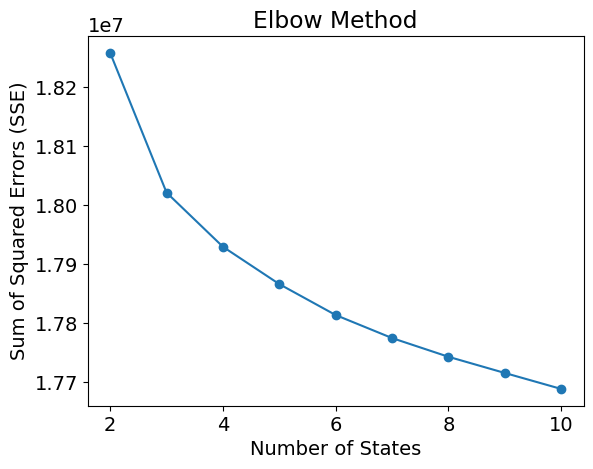

In [154]:
k_values = range(2, 11)
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of States')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

In [155]:
diff=[]
k_diff=[]
for i in range (1,len(sse)-1):
    k_diff.append(i+2)

    diff.append((sse[i+1]-sse[i])/(sse[i]-sse[i-1]))

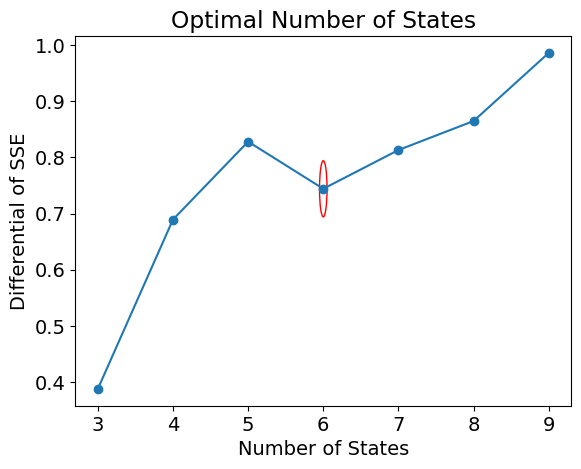

In [156]:

plt.plot(k_diff, diff, marker='o')
circle_radius = 0.05  
circle = plt.Circle((k_diff[3], diff[3]), circle_radius, color='r', fill=False)
plt.gca().add_patch(circle)

plt.title('Optimal Number of States')
plt.xlabel('Number of States')
plt.ylabel('Differential of SSE')
plt.show()


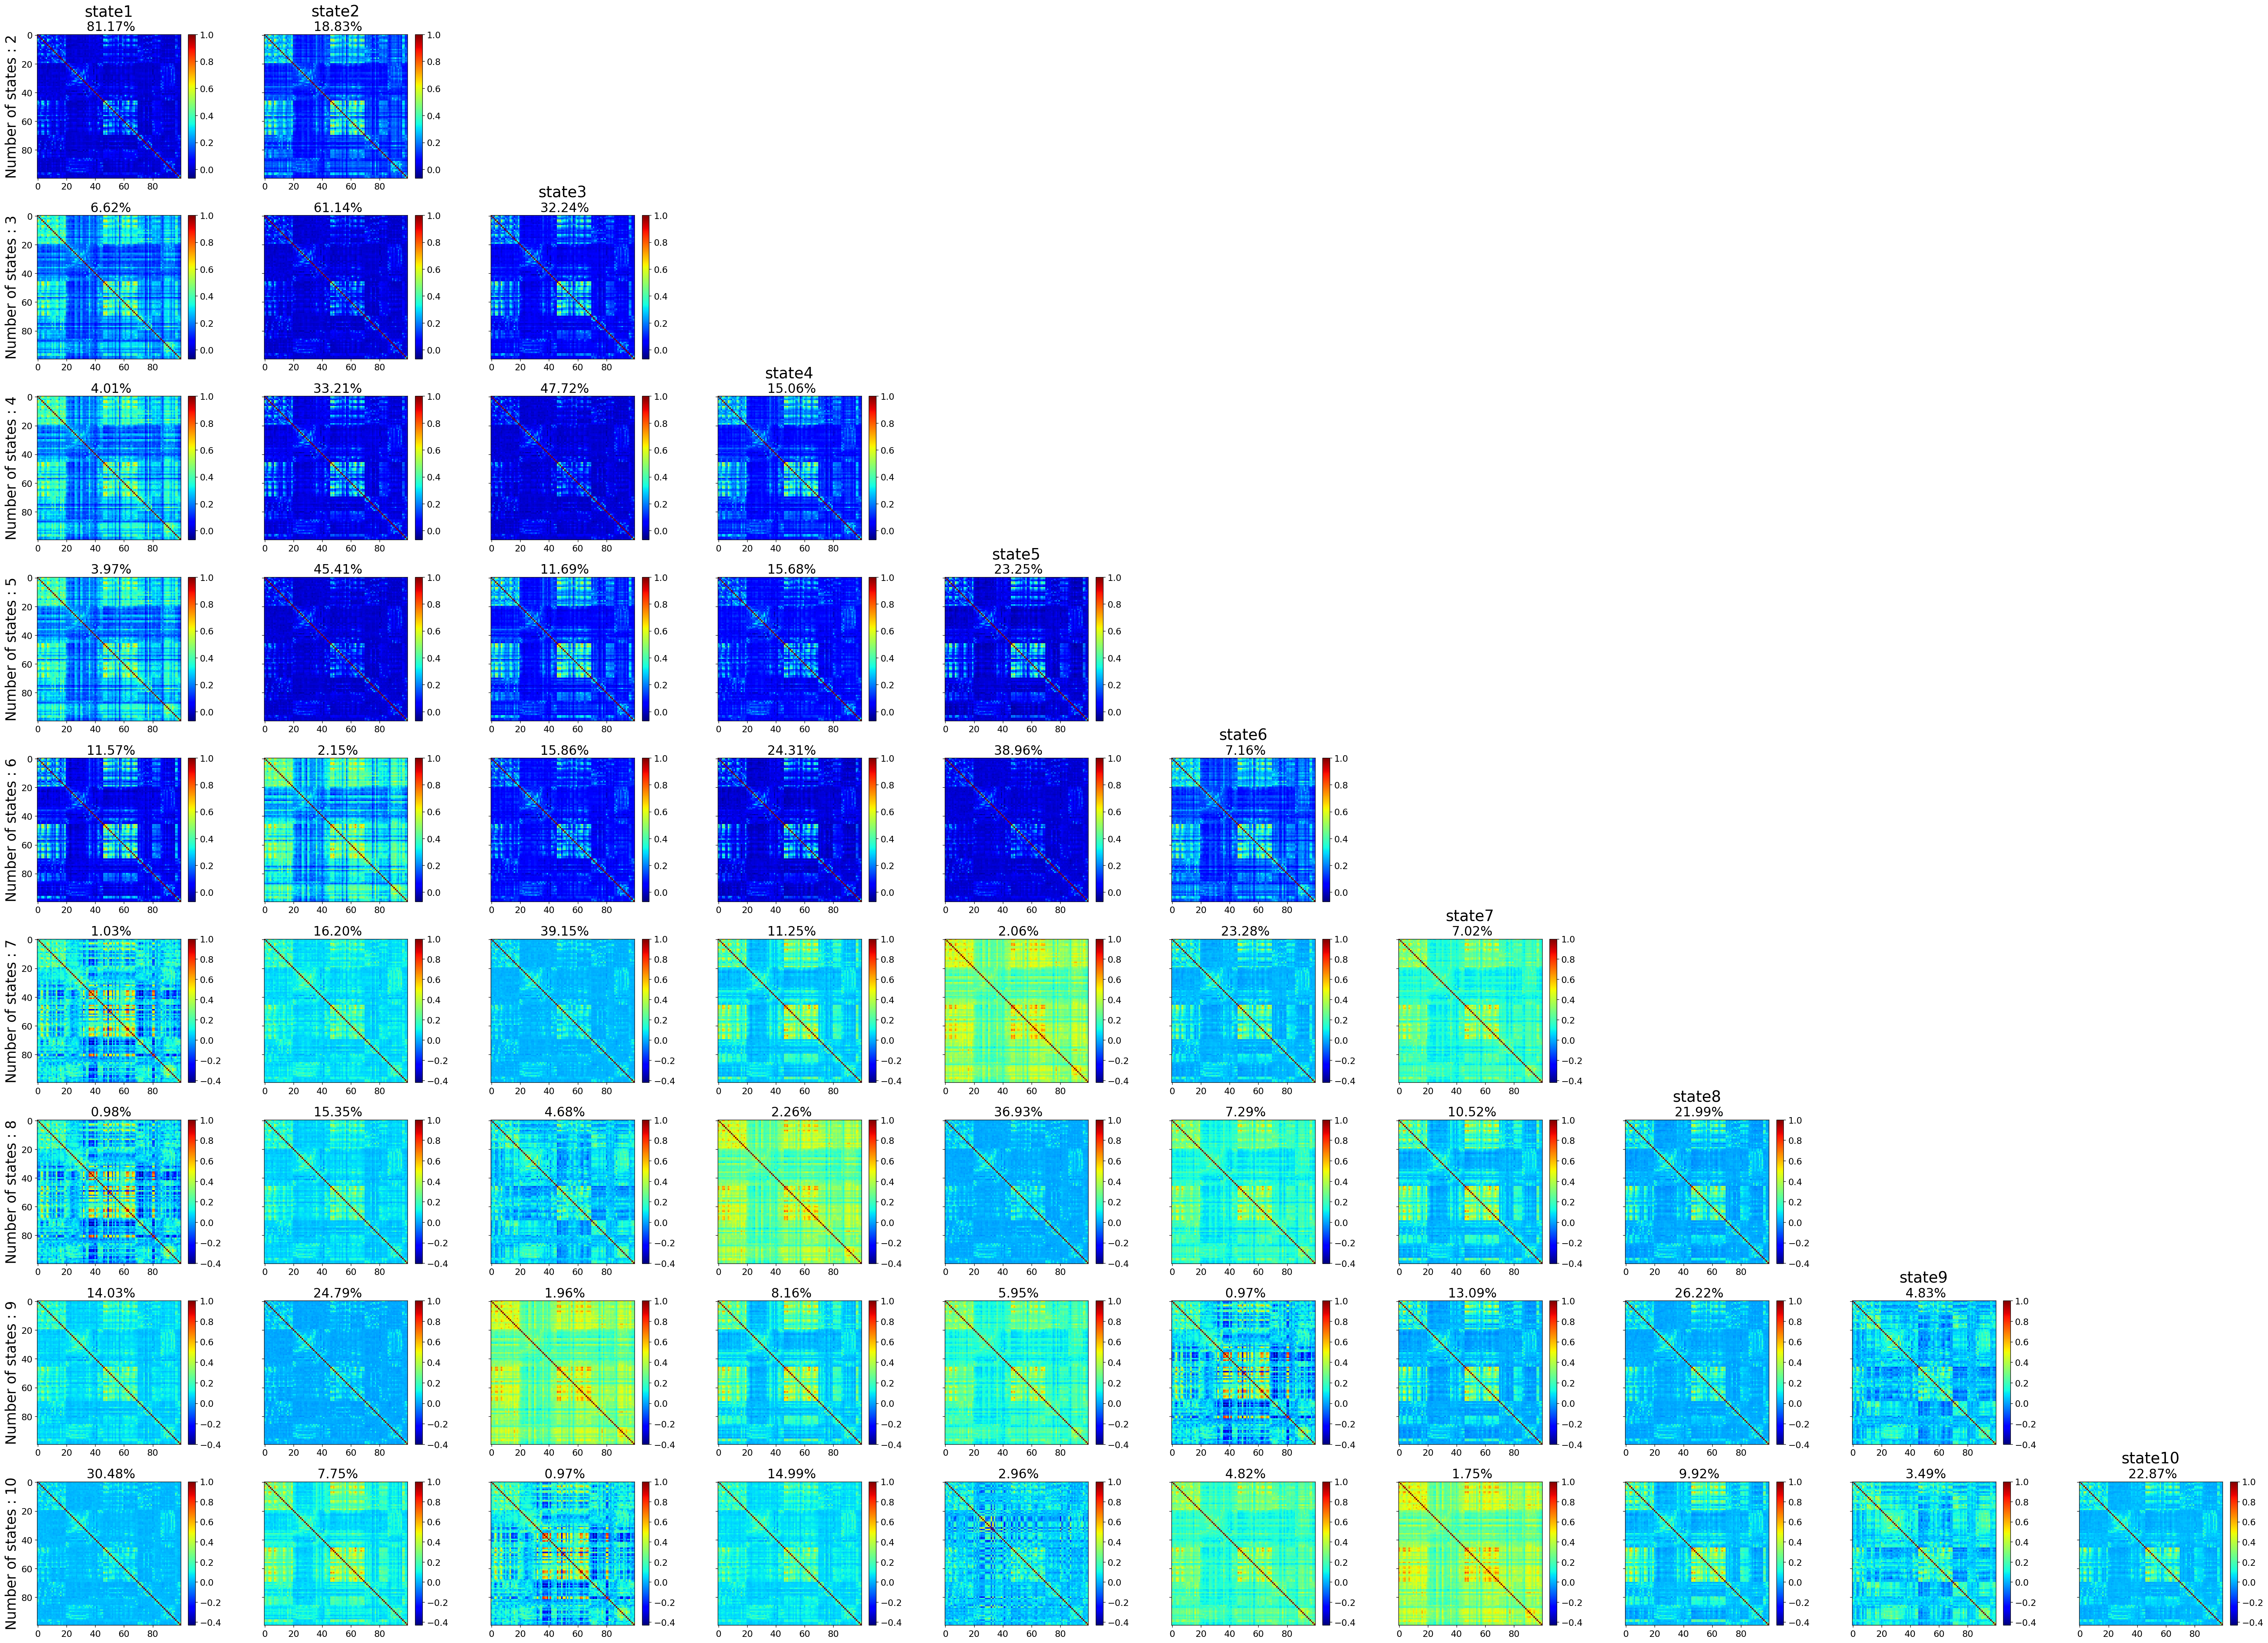

In [157]:
import matplotlib.pyplot as plt
import numpy as np

nrows, ncols = len(fcs_center), k_number
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=120, sharex=False, sharey=True)
cosine_mat =[]
for idx_K in range(len(fcs_center)):
    row_vals = [subgroup for subgroup in fcs_center[idx_K]]
    row_vmin = np.min([np.min(subgroup) for subgroup in row_vals])
    row_vmax = np.max([np.max(subgroup) for subgroup in row_vals])

    cosine_mat.append(cos_sim(fcs_center[idx_K]))
    for k in range(len(fcs_center[idx_K])):
        ax = axs[idx_K, k]
        vals = fcs_center[idx_K][k]
        percs = percents[idx_K][k]
        vals = sorting_fc (vals)

        im =ax.imshow(vals, cmap='jet', interpolation='none', vmin=row_vmin, vmax=row_vmax)
        if k ==0:
            ax.set_ylabel(f'Number of states : {idx_K+2}', fontsize=22)
    
        ax.text(0.5, 1.05, f' {percs:.2f}%', ha='center', va='center', transform=ax.transAxes, fontsize=20)

        if idx_K == 0 or k > idx_K:
            ax.set_title(f'state{k+1}', y=1.1, fontsize=24) 
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        

    for k in np.arange(k+1, ncols):
        fig.delaxes(axs[idx_K, k])

fig.tight_layout()
plt.show()


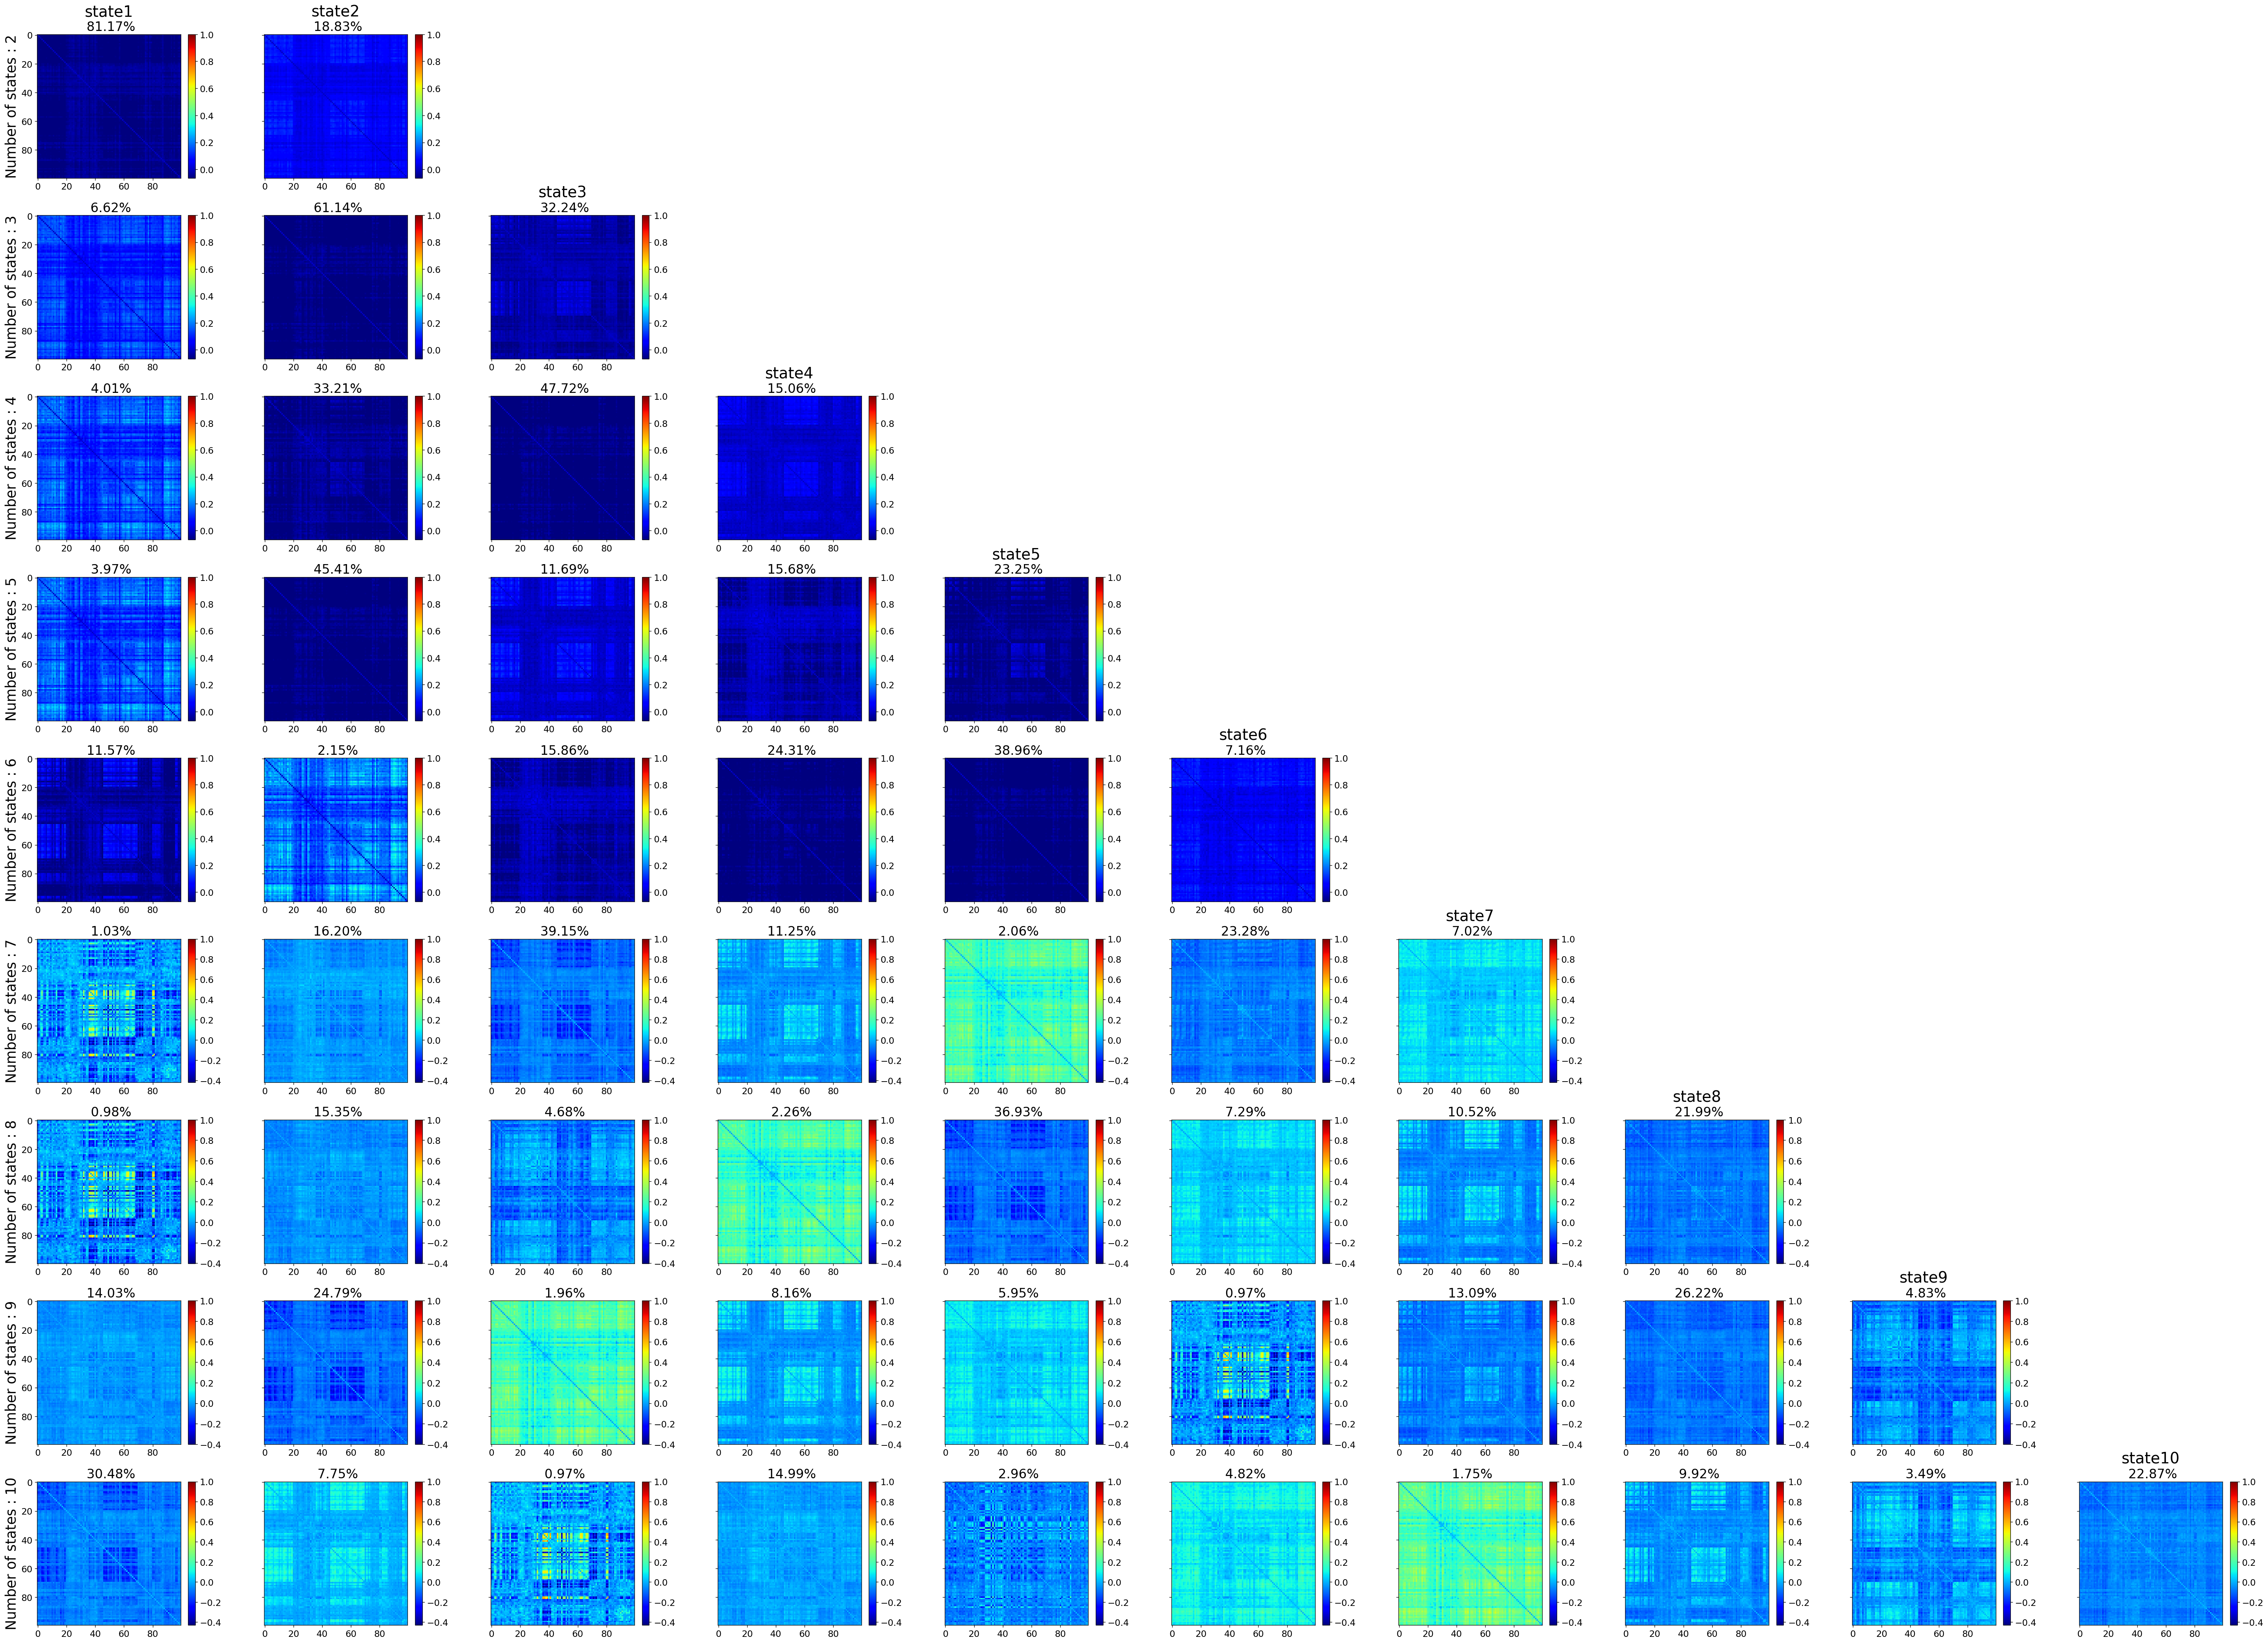

In [332]:
import matplotlib.pyplot as plt
import numpy as np
args.percentile =90
nrows, ncols = len(fcs_center), k_number
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=120, sharex=False, sharey=True)
cosine_mat =[]
demean_fcs =[]
for idx_K in range(len(fcs_center)):
    row_vals = [subgroup for subgroup in fcs_center[idx_K]]
    row_vmin = np.min([np.min(subgroup) for subgroup in row_vals])
    row_vmax = np.max([np.max(subgroup) for subgroup in row_vals])
    demean_mat=[]
    cosine_mat.append(cos_sim(fcs_center[idx_K]))
    for k in range(len(fcs_center[idx_K])):
        ax = axs[idx_K, k]
        vals = fcs_center[idx_K][k]
        array_fc = np.array(fcs_center[idx_K])
        mean_fc = np.nanmean(array_fc,axis =0)
        vals_demeaned = vals - mean_fc
        demean_mat.append(vals_demeaned) 
        percs = percents[idx_K][k]
        vals = sorting_fc (vals_demeaned)
        #vals = vals > np.percentile(vals, q=args.percentile)
        im =ax.imshow(vals, cmap='jet', interpolation='none', vmin=row_vmin, vmax=row_vmax)
        if k ==0:
            ax.set_ylabel(f'Number of states : {idx_K+2}', fontsize=22)
    
        ax.text(0.5, 1.05, f' {percs:.2f}%', ha='center', va='center', transform=ax.transAxes, fontsize=20)

        if idx_K == 0 or k > idx_K:
            ax.set_title(f'state{k+1}', y=1.1, fontsize=24) 
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    demean_fcs.append(demean_mat)    

    for k in np.arange(k+1, ncols):
        fig.delaxes(axs[idx_K, k])

fig.tight_layout()
plt.show()


In [ ]:
    threshold = np.percentile(fc, q=args.percentile)
    fc_binary = fc > threshold
    fc_binary = fc_binary.astype(int)
    np.fill_diagonal(fc_binary, 0)

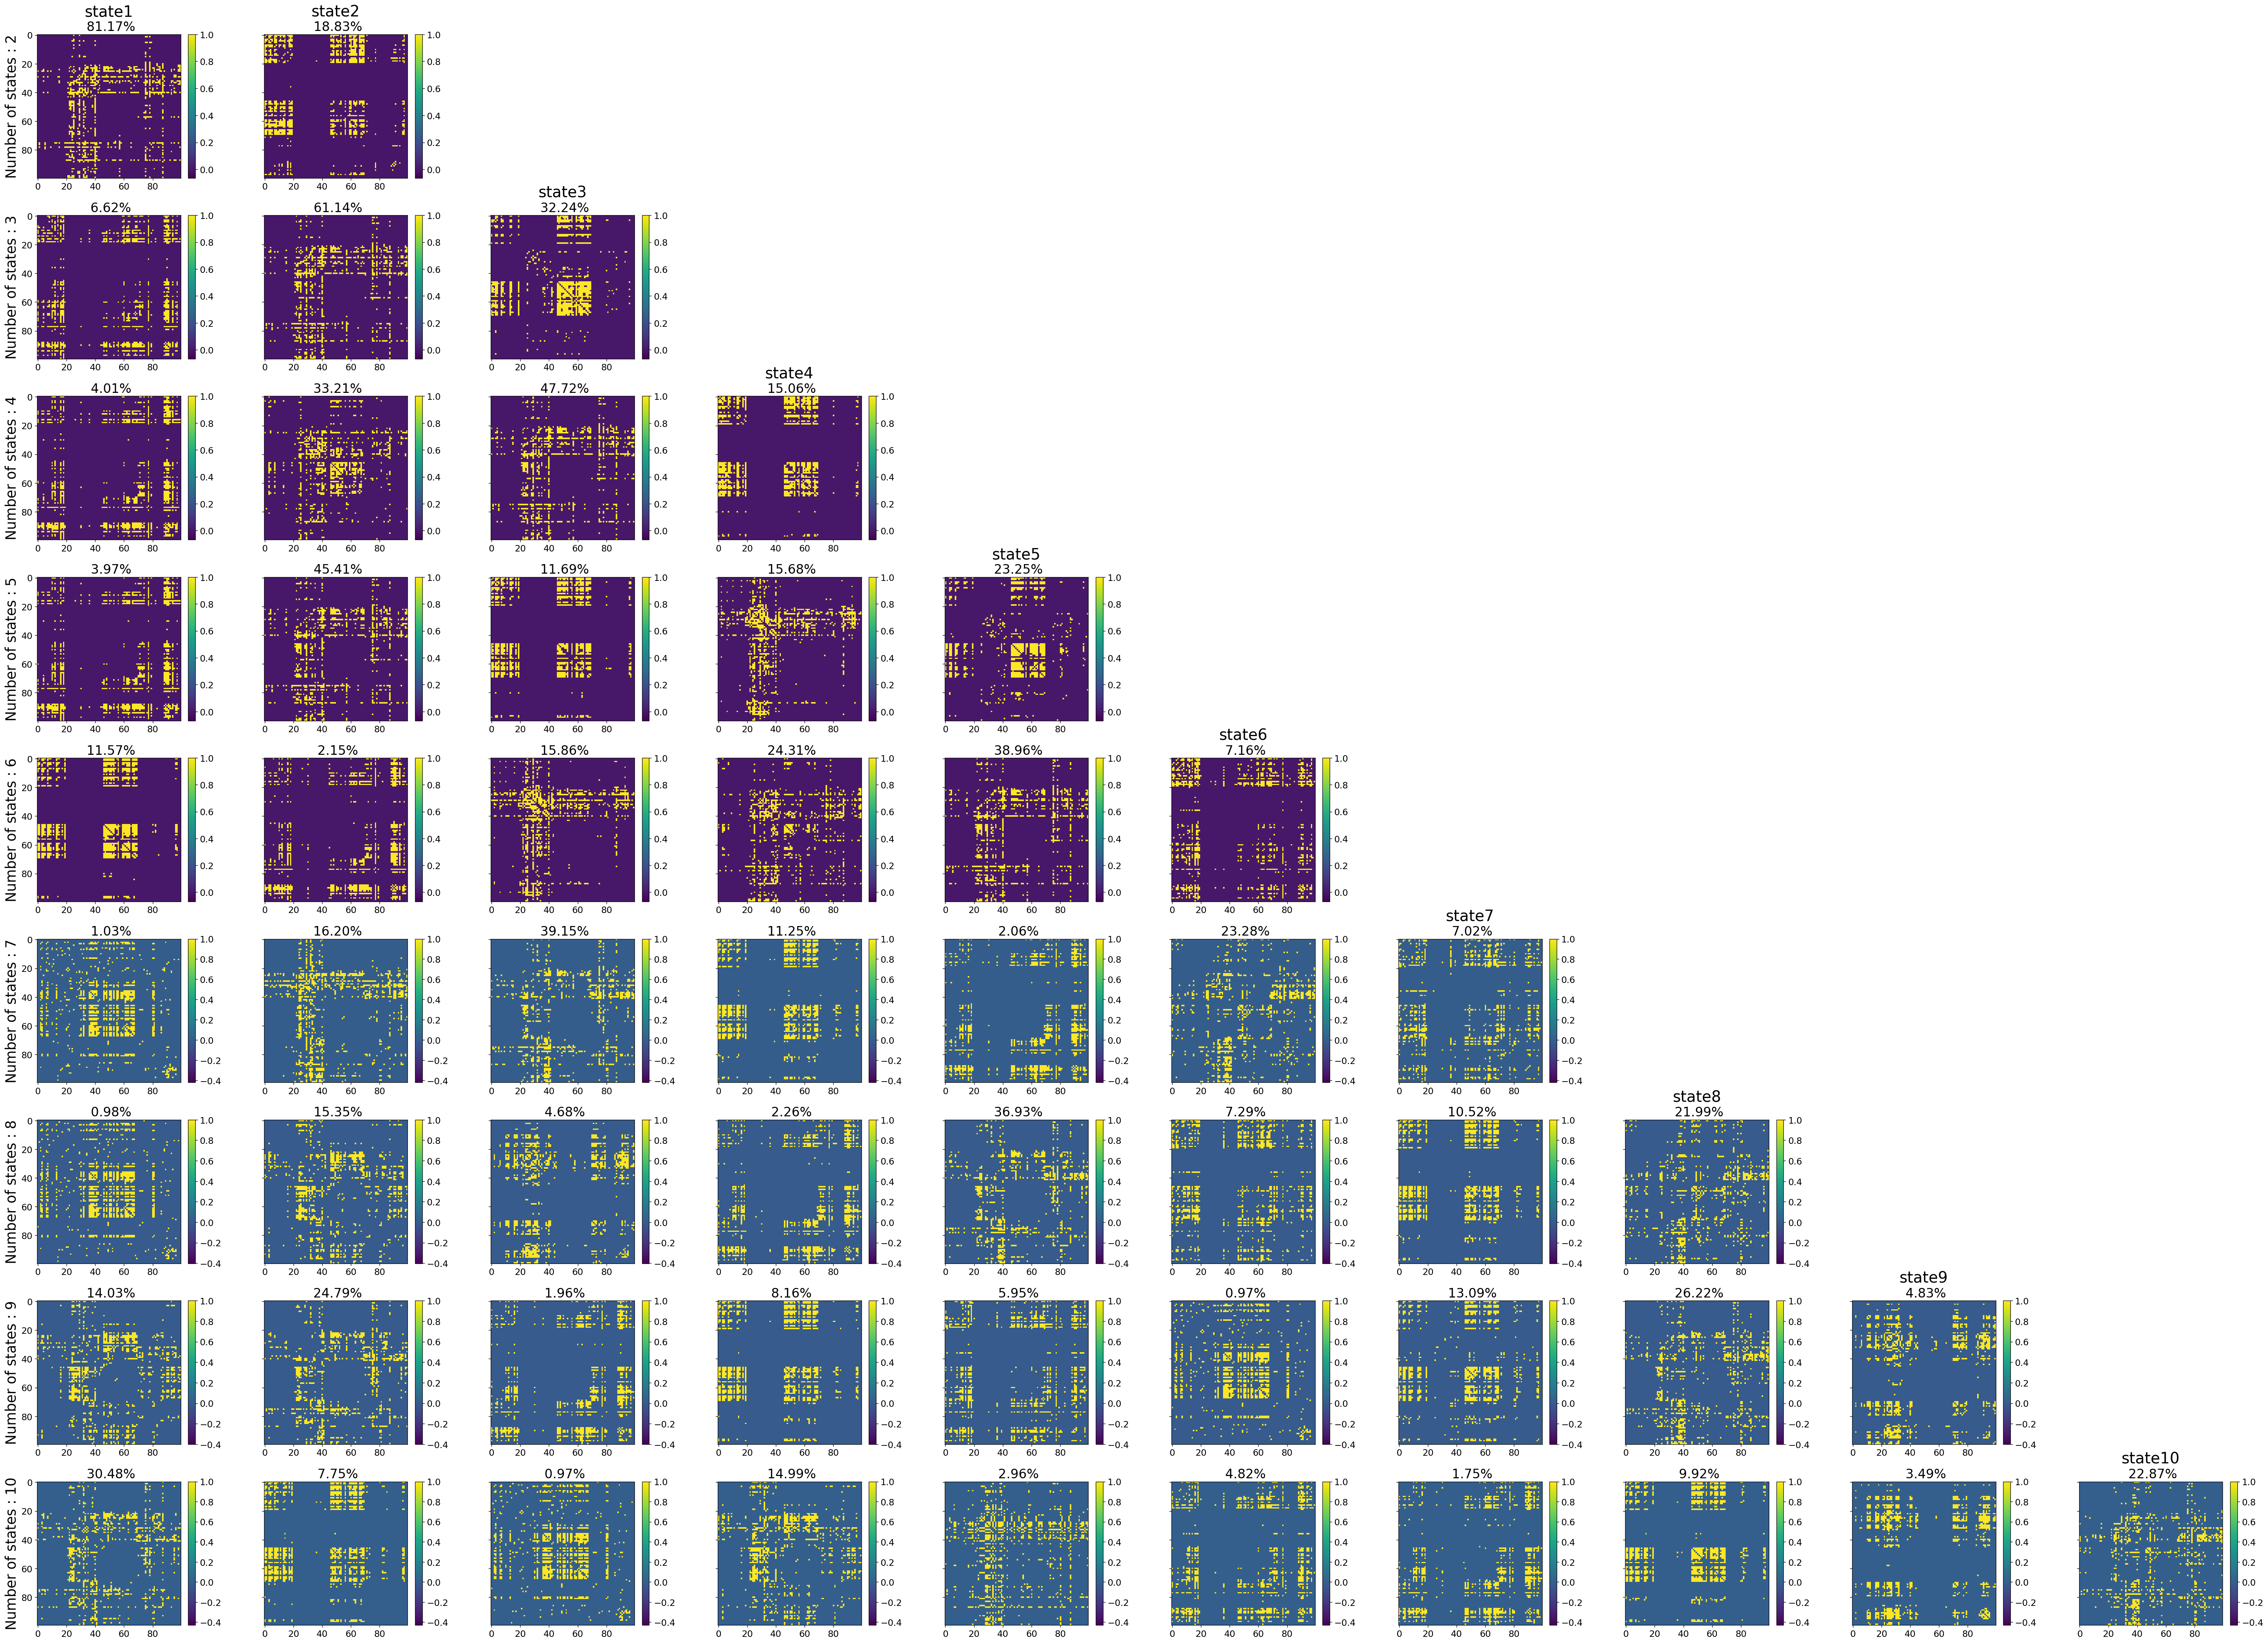

In [175]:
import matplotlib.pyplot as plt
import numpy as np
args.percentile =90
nrows, ncols = len(fcs_center), k_number
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=120, sharex=False, sharey=True)
cosine_mat =[]
demean_fcs =[]
for idx_K in range(len(fcs_center)):
    row_vals = [subgroup for subgroup in fcs_center[idx_K]]
    row_vmin = np.min([np.min(subgroup) for subgroup in row_vals])
    row_vmax = np.max([np.max(subgroup) for subgroup in row_vals])
    demean_mat=[]
    cosine_mat.append(cos_sim(fcs_center[idx_K]))
    for k in range(len(fcs_center[idx_K])):
        ax = axs[idx_K, k]
        vals = fcs_center[idx_K][k]
        array_fc = np.array(fcs_center[idx_K])
        mean_fc = np.nanmean(array_fc,axis =0)
        vals_demeaned = vals - mean_fc
        demean_mat.append(vals_demeaned) 
        percs = percents[idx_K][k]
        vals = sorting_fc (vals_demeaned)
        threshold = np.percentile(vals, q=args.percentile)
        fc_binary = vals > threshold
        fc_binary = fc_binary.astype(int)
        np.fill_diagonal(fc_binary, 0)
        #vals = vals > np.percentile(vals, q=args.percentile)
        im =ax.imshow(fc_binary, cmap='viridis', interpolation='none', vmin=row_vmin, vmax=row_vmax)
        if k ==0:
            ax.set_ylabel(f'Number of states : {idx_K+2}', fontsize=22)
    
        ax.text(0.5, 1.05, f' {percs:.2f}%', ha='center', va='center', transform=ax.transAxes, fontsize=20)

        if idx_K == 0 or k > idx_K:
            ax.set_title(f'state{k+1}', y=1.1, fontsize=24) 
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    demean_fcs.append(demean_mat)    

    for k in np.arange(k+1, ncols):
        fig.delaxes(axs[idx_K, k])

fig.tight_layout()
plt.show()


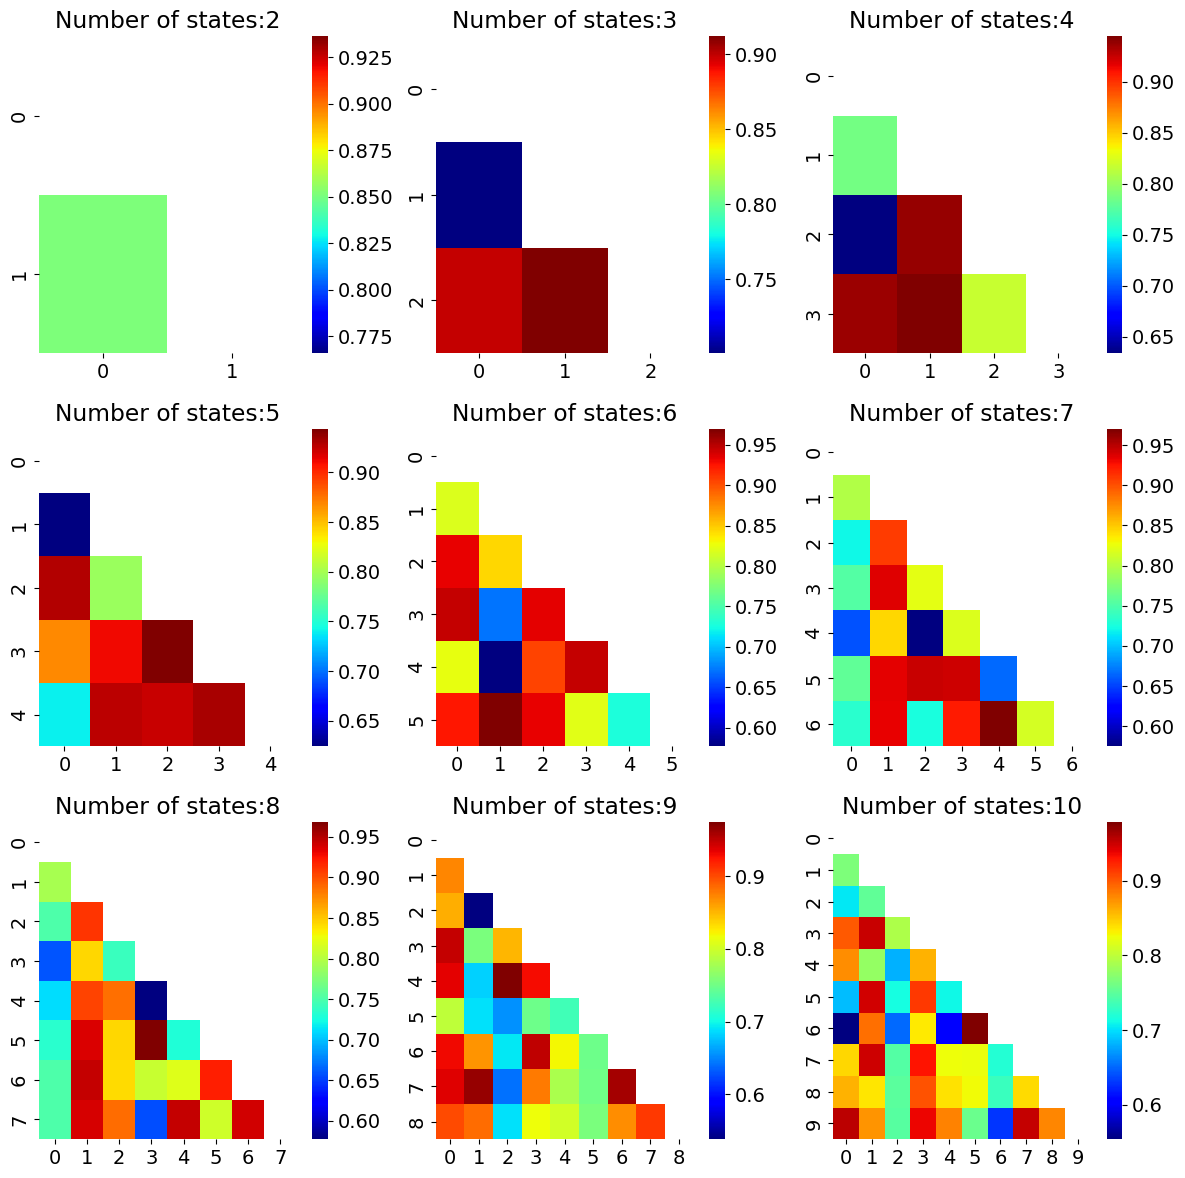

In [159]:
num_matrices = len(cosine_mat)
rows, cols = 3, 3 
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < num_matrices:
            matrix = cosine_mat[index]
            ax = axes[i, j]
            sns.heatmap(matrix, cmap='jet', cbar=True, ax=ax, annot=False, mask=np.triu(np.ones_like(matrix)))
            
            ax.set_title(f'Number of states:{index + 2}')

plt.tight_layout()
plt.show()

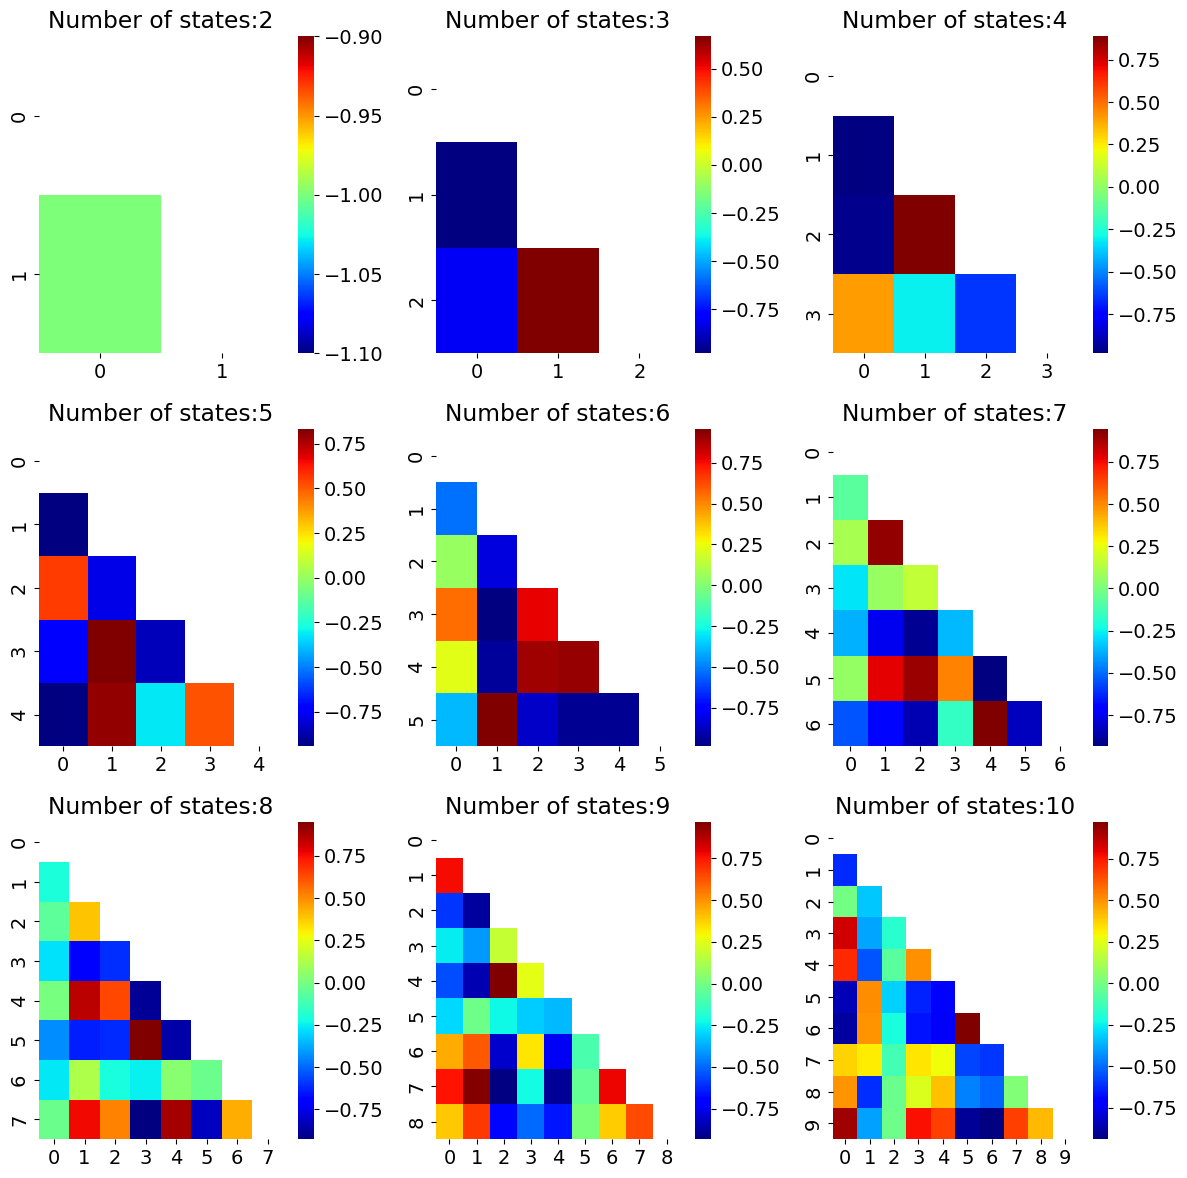

In [160]:
cosine_demean=[]
for idx_K in range (len(demean_fcs)):
    cosine_demean.append(cos_sim(demean_fcs[idx_K]))
num_matrices = len(cosine_demean)
rows, cols = 3, 3 
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < num_matrices:
            matrix = cosine_demean[index]
            ax = axes[i, j]
            sns.heatmap((matrix), cmap='jet', cbar=True, ax=ax, annot=False, mask=np.triu(np.ones_like(matrix)))
            
            ax.set_title(f'Number of states:{index + 2}')

plt.tight_layout()
plt.show()

# state 6

In [161]:
print(len(demean_fcs[4]))

6


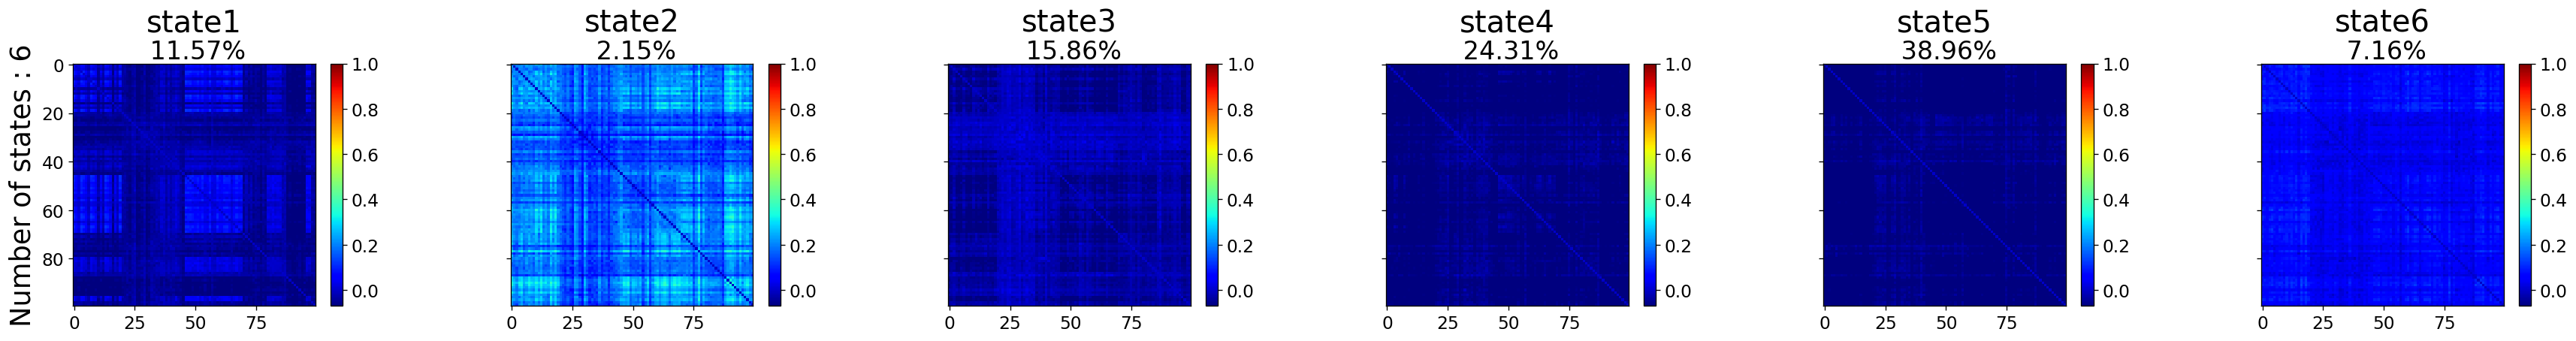

In [162]:
import matplotlib.pyplot as plt
import numpy as np

nrows, ncols = 1, 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=120, sharex=False, sharey=True)
cosine_mat =[]
idx_K =4
row_vals = [subgroup for subgroup in fcs_center[idx_K]]
row_vmin = np.min([np.min(subgroup) for subgroup in row_vals])
row_vmax = np.max([np.max(subgroup) for subgroup in row_vals])
for k in range(len(fcs_center[idx_K])):
    ax = axs[k]
    vals = demean_fcs[idx_K][k]
    percs = percents[idx_K][k]
    vals = sorting_fc (vals)
    im =ax.imshow(vals, cmap='jet', interpolation='none', vmin=row_vmin, vmax=row_vmax)
    if k ==0:
        ax.set_ylabel(f'Number of states : {idx_K+2}', fontsize=22)
    
    ax.text(0.5, 1.05, f' {percs:.2f}%', ha='center', va='center', transform=ax.transAxes, fontsize=20)
    ax.set_title(f'state{k+1}', y=1.1, fontsize=24) 
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()


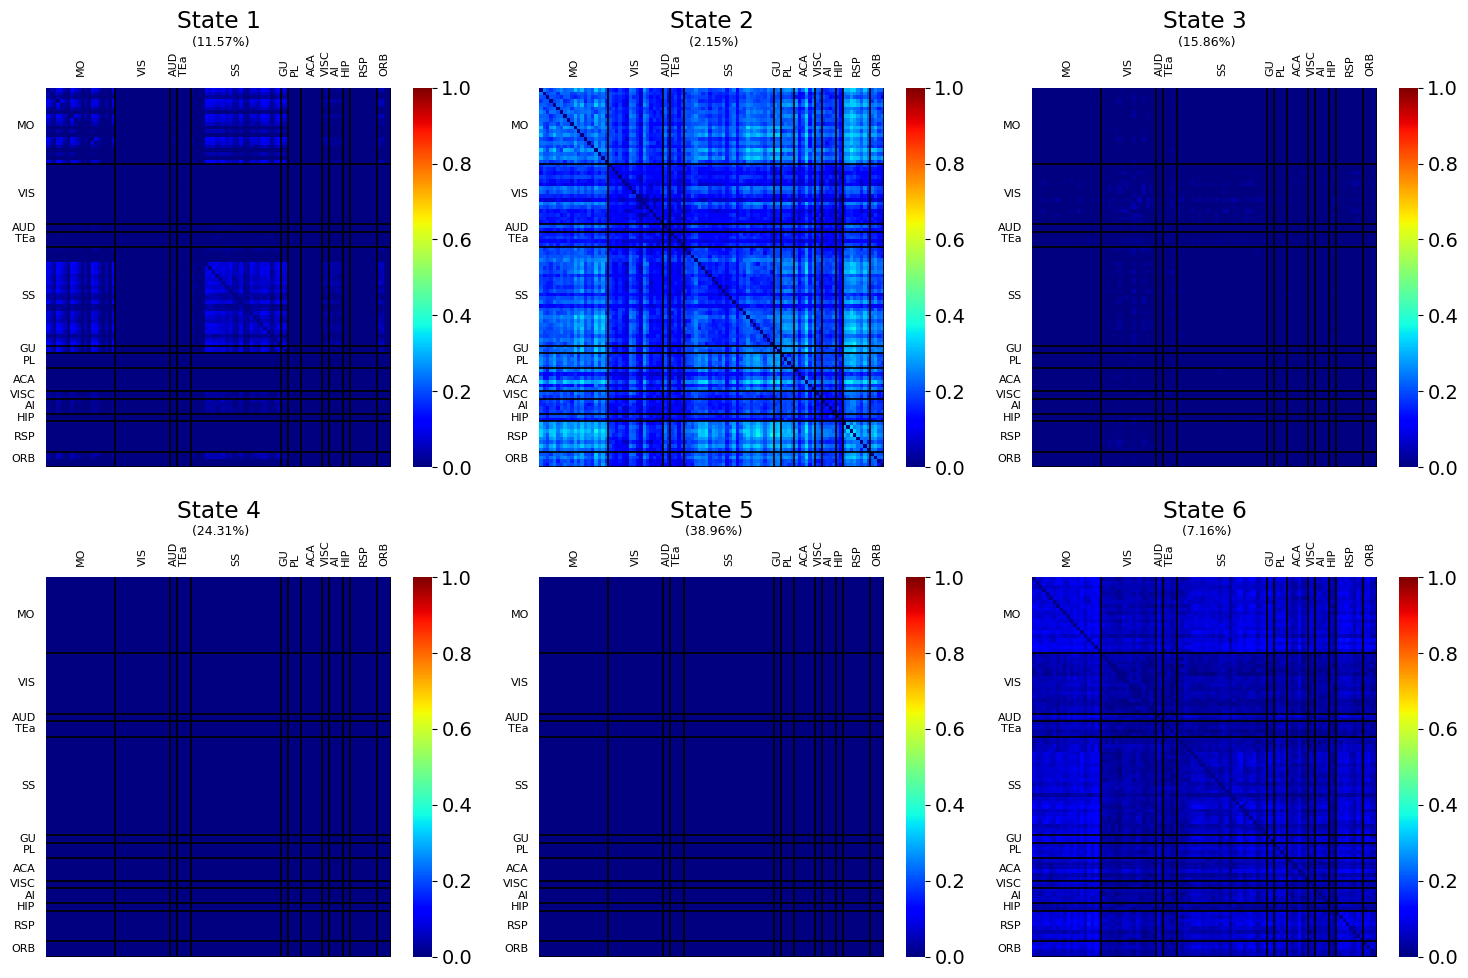

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
num_rows =2
idx_K = 4
num_states = len(fcs_center[idx_K])
num_cols = num_states // num_rows + (num_states % num_rows > 0)

 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
args.percentile =90
axes = axes.flatten()
for k_state in range(num_states):
    ax = axes[k_state] if num_states > 1 else axes 
    fc = demean_fcs[idx_K][k_state]

    fc = sorting_fc (fc)
    sns.heatmap(fc, cmap='jet', fmt=".2f", cbar=True, vmin=0, vmax=1, ax=ax)
    percs = percents[idx_K][k_state]
    ax.text(0.5, 1.12, f' ({percs:.2f}%)', ha='center', va='center', transform=ax.transAxes, fontsize=9)
    count2 = 0
    for acro_c, length_c in info_anno_coarse_fc.items():
        count2 += length_c
        ax.text(-3, count2 - length_c / 2, acro_c, ha='right', va='center', fontsize=8)
        ax.text(count2 - length_c / 2, -3, acro_c, ha='center', va='bottom', fontsize=8, rotation=90)
        ax.axvline(x=count2, color='black', linestyle='-', linewidth=1.2)
        ax.axhline(y=count2, color='black', linestyle='-', linewidth=1.2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'State {k_state + 1}', pad=43)

plt.tight_layout()
plt.show()


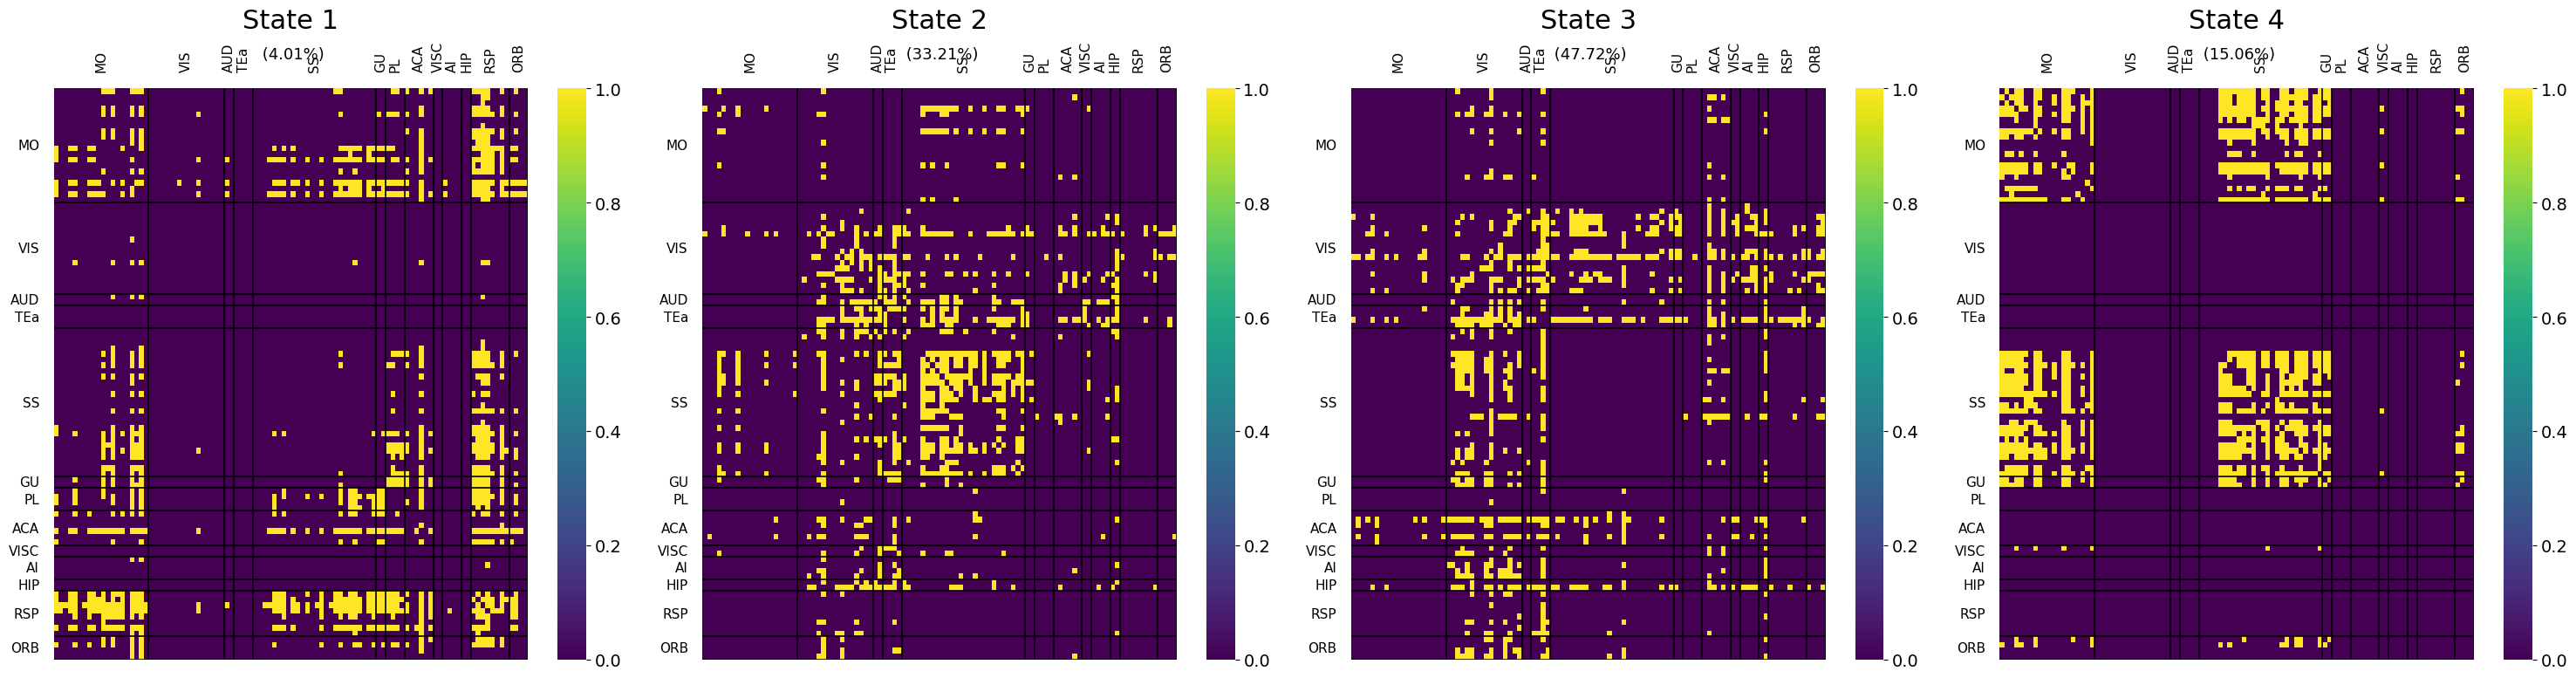

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns
num_rows =1
idx_K = 2
num_states = len(fcs_center[idx_K])
num_cols = num_states // num_rows + (num_states % num_rows > 0)

 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 8))
args.percentile =90
axes = axes.flatten()
for k_state in range(num_states):
    ax = axes[k_state] if num_states > 1 else axes 
    fc = demean_fcs[idx_K][k_state]

    fc = sorting_fc (fc)
    threshold = np.percentile(fc, q=args.percentile)
    fc_binary = fc > threshold
    fc_binary = fc_binary.astype(int)
    np.fill_diagonal(fc_binary, 0)
    sns.heatmap(fc_binary, cmap='viridis', fmt=".2f", cbar=True, vmin=0, vmax=1, ax=ax)
    percs = percents[idx_K][k_state]
    ax.text(0.5, 1.06, f' ({percs:.2f}%)', ha='center', va='center', transform=ax.transAxes, fontsize=13)
    count2 = 0
    for acro_c, length_c in info_anno_coarse_fc.items():
        count2 += length_c
        ax.text(-3, count2 - length_c / 2, acro_c, ha='right', va='center', fontsize=11)
        ax.text(count2 - length_c / 2, -3, acro_c, ha='center', va='bottom', fontsize=11, rotation=90)
        ax.axvline(x=count2, color='black', linestyle='-', linewidth=1.2)
        ax.axhline(y=count2, color='black', linestyle='-', linewidth=1.2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'State {k_state + 1}', pad=50, fontsize=22)
plt.tight_layout()
plt.show()


# edges

In [365]:
FC_path = f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/nws/6_states/demeaned/edges'
fc_edges=[]
for i_state in range (len(demean_fcs)):
    fc_st =[]
    for k_state in range (len( demean_fcs[i_state])): 
        fc = demean_fcs[i_state][k_state]
        #fc = sorting_fc (fc)
        args.percentile=90
        threshold = np.percentile(fc, q=args.percentile)
        fc_binary = fc > threshold
        fc_binary = fc_binary.astype(int)
        np.fill_diagonal(fc_binary, 0)
        edges = np.stack(np.where(np.tril(fc_binary, k=-1)), axis=-1)
        nw_edges_file = f'state{i_state+2}/s{k_state+1}/k{i_state+2}_state{k_state+1}_desc-nw-edges.txt' 
        with open(f'{FC_path}/{nw_edges_file}', 'w', newline='') as f:
            wr = csv.writer(f, delimiter='\t')
            wr.writerows(edges)
        fc_st .append(fc_binary)
    fc_edges.append(fc_st)

In [235]:
def mean_fc_acro (matrix):
    mean_fc_mat = np.zeros((100,1))
    count1 =0
    acro_edge=[]
    for acro_c, length_c in info_anno_coarse_fc.items():
        summ_all = np.sum(matrix[count1:length_c+count1,count1:length_c+count1])
        rois_realfc= roi_list[count1:length_c+count1]
        count1=count1+length_c
        for i in (rois_realfc):
            mean_fc_mat[i,:] = (summ_all)
        acro_edge.append([acro_c, summ_all])

    return mean_fc_mat, acro_edge


In [237]:
mat2=[]
acro2=[]
for state in range (len(fc_edges)):
    mat1=[]
    acro1=[]
    for k in range (len(fc_edges[state])):
        mat,acro_edge = mean_fc_acro(fc_edges[state][k])
        mat1.append(mat)
        acro1.append(acro_edge)
    mat2.append(mat1)
    acro2.append(acro1)

In [169]:
for i_s in range (len(mat2)):
    mat = mat2[i_s]
    args_num_states =len(mat)
    mean_activation= f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/mean_activation_30'
    nwtype = mean_activation
    def save_as_nifti(args, parcels_img, roi_labels, X, name):
        parcels = parcels_img.numpy()
        comms_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            comms_img += (parcels == roi) * X[idx].item()

        parcels_img.new_image_like(
                comms_img
            ).to_filename(f'{nwtype}/group__states{args_num_states }__state{num_state+1}_mean_activation.nii.gz')

    for i in range (len(mat)):
        num_state = i
        save_as_nifti(args, parcels_img, roi_labels, mat[num_state], 'mean_actiavtion')

# static

In [61]:
args.percentile =90
def edges(fc):
    fc = fc[np.tril_indices(fc.shape[0], k=-1)]
    fc[np.isnan(fc)] = 0.0
    fc = fc > np.percentile(fc, q=args.percentile) # keep only top 10% edges, this removes neg. edges
    fc_ = np.zeros((args.num_rois, args.num_rois))
    fc_[np.tril_indices(fc_.shape[0], k=-1)] = fc
    fc_ = (fc_ + fc_.T)
    return fc_
    

In [104]:
fc_static_edges = edges(fc_static)

def comms(fc):
    kmeans = KMeans(
        n_clusters=args.num_comms,
        init='k-means++', n_init=50,
        random_state=args.SEED,
    ).fit(fc)
    c = kmeans.predict(fc)
    comms = np.zeros((args.num_rois, args.num_comms))
    for comm in range(args.num_comms):
        comms[:, comm] = (c == comm).astype(int)
    return comms
args.num_comms = 7
args.SEED = 100
network_fc = comms(fc_static)


In [131]:
static_nws_path =f'/home/saba/mice/data/roi/govinda_cortex/static_nws'
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    for comm in range(args.num_comms):
        comms_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            comms_img += (parcels == roi) * X[idx, comm]

        parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{static_nws_path}/comm{comm}.nii.gz')

    out_file = f'{static_nws_path}/grouplevel_static_fullfc_kmeans_disjoint-{args.num_comms}.nii.gz'
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = [
        f'{static_nws_path}/comm{comm}.nii.gz'
        for comm in range(args.num_comms)
    ]
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline
    res = tcat.run()

    for comm in range(args.num_comms):
        try:
            os.remove(f'{static_nws_path}/comm{comm}.nii.gz')
        except:
            pass
save_as_nifti(args, parcels_img, roi_labels, network_fc, 'kmeans')

240308-12:54:03,505 nipype.interface INFO:
	 stderr 2024-03-08T12:54:03.505496:++ 3dTcat: AFNI version=AFNI_22.2.04 (Jul 28 2022) [64-bit]
240308-12:54:03,510 nipype.interface INFO:
	 stderr 2024-03-08T12:54:03.510807:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240308-12:54:03,512 nipype.interface INFO:
	 stderr 2024-03-08T12:54:03.512285:*+ WARNING: Set TR of output dataset to 1.0 s
240308-12:54:03,621 nipype.interface INFO:
	 stderr 2024-03-08T12:54:03.621189:++ elapsed time = 0.1 s


# mean activation

In [139]:
def windowing_ts(signal, window_width, window_type='hann'):
    step_size = 1
    end = len(signal) - window_width + 1
    data_windows=[]
    data_tapred =[]
    for i in range(0, end, step_size):
        window_ts = signal[i:i + window_width]
        data_windows.append(window_ts)
        # Apply tapered window
        if window_type == 'hann':
            tapered_window = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(window_width) / (window_width - 1))
            window_ts = window_ts * tapered_window[:, np.newaxis]
        #mean_values = np.nanmean(window_ts, axis=0) 
        #demeaned_data = window_ts - mean_values 
        #fc_w = finding_fc(demeaned_data)
        window_ts= stats.zscore(window_ts, axis=0, nan_policy='omit')
        data_tapred.append(window_ts)
    
    return data_windows, data_tapred
data_windows, data_tapred = windowing_ts(concatenated_data,args.window_width)

In [140]:
print(len(data_windows),data_windows[0].shape)

54751 (30, 100)


In [147]:
label_indices = {}

for i, label in enumerate(labels_list[5]):
    if label not in label_indices:
        label_indices[label] = [i]
    else:
        label_indices[label].append(i)

label_matrices = {label: [] for label in label_indices}

for label, indices in label_indices.items():
    for idx in indices:
        label_matrices[label].append(data_windows[idx])

In [148]:
mean_matrices = {}

for label, matrices in label_matrices.items():
    stacked_matrices = np.stack(matrices, axis=0)
    mean_matrix = np.nanmean(stacked_matrices, axis=0)
    mean_matrix = np.nanmean(mean_matrix , axis =0)
    mean_matrices[label] = mean_matrix


In [149]:
args_num_states =len(mean_matrices)
mean_activation= f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/mean_activation'
nwtype = mean_activation
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    comms_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        comms_img += (parcels == roi) * X[idx]

    parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{nwtype}/group__states{args_num_states }__state{num_state+1}_mean_activation.nii.gz')

for i in range (len(mean_matrices)):
    num_state = i
    save_as_nifti(args, parcels_img, roi_labels, mean_matrices[num_state], 'mean_actiavtion')

In [86]:
print(concatenated_data.shape)

(54780, 100)


In [94]:
label_matrices = {label: [] for label in label_indices}

for label, indices in label_indices.items():
    points =np.zeros((len(indices),100))
    count = 0
    for idx in indices:
        points[count,:] = (concatenated_data[idx,:])
        count = count+1
    label_matrices[label].append(points)

In [95]:
mean_matrices = {}

for label, matrices in label_matrices.items():
    mean_matrix = np.nanmean(matrices[0] , axis =0)
    mean_matrices[label] = mean_matrix

In [96]:
args_num_states =len(mean_matrices)
mean_activation= f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/mean_activation'
nwtype = mean_activation
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    comms_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        comms_img += (parcels == roi) * X[idx]

    parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{nwtype}/group__states{args_num_states }__state{num_state+1}_mean_activation.nii.gz')

for i in range (len(mean_matrices)):
    num_state = i
    save_as_nifti(args, parcels_img, roi_labels, mean_matrices[num_state], 'mean_actiavtion')

# Networks

In [366]:
args_num_states = len([fc_edges[0]])
args_num_states

1

In [382]:
states = fc_edges[1]

In [89]:
args.percentile =90
def edges(fc):
    fc = fc[np.tril_indices(fc.shape[0], k=-1)]
    fc[np.isnan(fc)] = 0.0
    fc = fc > np.percentile(fc, q=args.percentile) # keep only top 10% edges, this removes neg. edges
    fc_ = np.zeros((args.num_rois, args.num_rois))
    fc_[np.tril_indices(fc_.shape[0], k=-1)] = fc
    fc_ = (fc_ + fc_.T)
    return fc_
    

In [370]:


dataset_states_df = []
    
for i, center_fc in enumerate(states):
    FC = center_fc
    #edge = edges(FC)
    df = pd.DataFrame({
        'state': [i],
        'center_fc': [FC],
        #'edge_fc' : [edge]
    })
    dataset_states_df.append(df)

dataset_states_df = pd.concat(dataset_states_df, ignore_index=True)
dataset_states_df.sort_values(by=['state']).reset_index(drop=True)

state                                          center_fc
0      0  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...
1      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [377]:

def comms(fc):
    kmeans = KMeans(
        n_clusters=args.num_comms,
        init='k-means++', n_init=50,
        random_state=args.SEED,
    ).fit(fc)
    c = kmeans.predict(fc)
    comms = np.zeros((args.num_rois, args.num_comms))
    for comm in range(args.num_comms):
        comms[:, comm] = (c == comm).astype(int)
    return comms
args.num_comms = 2
args.SEED = 100
dataset_states_df['dsj_comms'] = dataset_states_df['center_fc'].apply(comms)

In [378]:
dataset_states_df.head()

state                                          center_fc  \
0      0  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...   
1      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                           dsj_comms  
0  [[0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0...  
1  [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...

In [381]:
args_num_states = len(dataset_states_df)
dynamic_nws_edges_path = f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/nws/6_states/edges'
dynamic_nws_fullfc_path = f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/nws/6_states/fullfc'
dynamic_demeaned_path = f'/home/saba/mice/data/roi/govinda_cortex/dynamic_nws/nws/6_states/demeaned/kmeans'
nwtype = dynamic_demeaned_path
def save_as_nifti(args, parcels_img, roi_labels, X, name):
    parcels = parcels_img.numpy()
    for comm in range(args.num_comms):
        comms_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            comms_img += (parcels == roi) * X[idx, comm]

        parcels_img.new_image_like(
            comms_img
        ).to_filename(f'{nwtype}/comm{comm}.nii.gz')

    out_file = f'{nwtype}/group__{args_num_states}numstates_{args.num_comms}net_state{num_state+1}_disjointkmeans.nii.gz'
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = [
        f'{nwtype}/comm{comm}.nii.gz'
        for comm in range(args.num_comms)
    ]
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline
    res = tcat.run()

    for comm in range(args.num_comms):
        try:
            os.remove(f'{nwtype}/comm{comm}.nii.gz')
        except:
            pass
for i in range (len(dataset_states_df)):
    num_state = i
    save_as_nifti(args, parcels_img, roi_labels, dataset_states_df['dsj_comms'][num_state], 'kmeans')

240313-17:24:36,681 nipype.interface INFO:
	 stderr 2024-03-13T17:24:36.681549:++ 3dTcat: AFNI version=AFNI_22.2.04 (Jul 28 2022) [64-bit]
240313-17:24:36,683 nipype.interface INFO:
	 stderr 2024-03-13T17:24:36.683669:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240313-17:24:36,684 nipype.interface INFO:
	 stderr 2024-03-13T17:24:36.684841:*+ WARNING: Set TR of output dataset to 1.0 s
240313-17:24:36,735 nipype.interface INFO:
	 stderr 2024-03-13T17:24:36.735477:++ elapsed time = 0.1 s
240313-17:24:37,296 nipype.interface INFO:
	 stderr 2024-03-13T17:24:37.296611:++ 3dTcat: AFNI version=AFNI_22.2.04 (Jul 28 2022) [64-bit]
240313-17:24:37,298 nipype.interface INFO:
	 stderr 2024-03-13T17:24:37.298706:*+ WARNING: can't apply -rlt option -- Not enough points per input dataset.
240313-17:24:37,299 nipype.interface INFO:
	 stderr 2024-03-13T17:24:37.299823:*+ WARNING: Set TR of output dataset to 1.0 s
240313-17:24:37,348 nipype.interface INFO:
	 stderr 2024-03

In [ ]:
matrix_A = dataset_states_df['dsj_comms'][0]
matrix_B = dataset_states_df['dsj_comms'][1]
matrix_A = matrix_A.T
matrix_B = matrix_B.T
cosine_sim = cosine_similarity(matrix_A, matrix_B)

In [ ]:
# Assuming 'cosine_sim' is your cosine similarity matrix
sns.heatmap(cosine_sim, annot=True, cmap='viridis', fmt=".2f", xticklabels=["Net 1", "Net 2", "Net 3"], yticklabels=["Net 1", "Net 2", "Net 3"])
plt.title('Cosine Similarity Between States 0 and 1')
plt.show()

# similarity to static networks

In [98]:
nws_path = f'/home/saba/mice/data/roi/govinda_cortex'
static_7nws =ants.image_read(f'{nws_path}/static_nws/grouplevel_static_fullfc_kmeans_disjoint-7.nii.gz')
args.num_state = 6
args.num_nws = 7
dynamic_7nws =[]
for i in range (args.num_state):
    nws_state = ants.image_read(f'{nws_path}/dynamic_nws/nws/6_states/fullfc/group_fullfc_states6_7net_state{i+1}_disjointkmeans.nii.gz')
    dynamic_7nws.append(nws_state)


In [108]:
print(network_fc.shape)

(100, 7)


In [109]:
print(dataset_states_df['dsj_comms'][0].shape)

(100, 7)


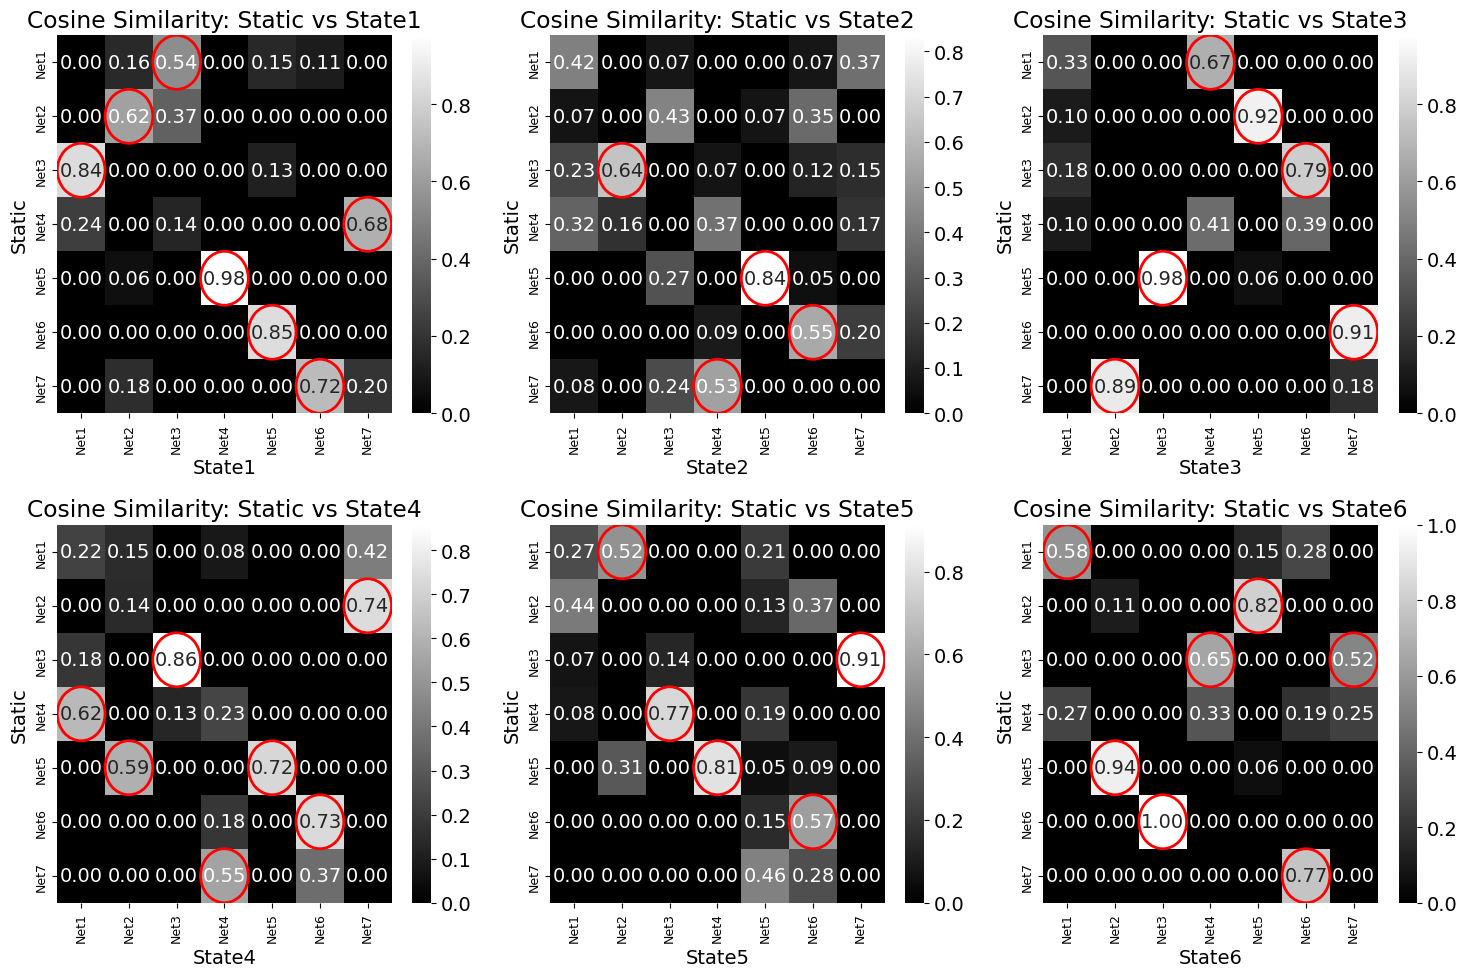

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
for i in range(6):
    matrix_A = network_fc
    matrix_B = dataset_states_df['dsj_comms'][i]
    matrix_A = matrix_A.T
    matrix_B = matrix_B.T

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(matrix_A, matrix_B)
    mask = np.abs(cosine_sim) > 0.5
    # Visualize the cosine similarity matrix
    ax = axes[i//3, i%3]  # Get the appropriate subplot axis
    sns.heatmap(cosine_sim, annot=True, cmap='gray', fmt=".2f", ax=ax,
                xticklabels=["Net1", "Net2", "Net3", "Net4", "Net5", "Net6", "Net7"],
                yticklabels=["Net1", "Net2", "Net3", "Net4", "Net5", "Net6", "Net7"])
    ax.set_title(f'Cosine Similarity: Static vs State{i+1}')
    ax.set_xlabel(f'State{i+1}')
    ax.set_ylabel('Static')
    # Circle cells with cosine similarity above 0.5
    for i in range(len(cosine_sim)):
        for j in range(len(cosine_sim[i])):
            if mask[i, j]:
                ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.5, color='red', fill=False, lw=2))
    ax.tick_params(axis='x', labelsize=9)  # Font size for x tick labels
    ax.tick_params(axis='y', labelsize=9)  # Font size for y tick labels
      
plt.tight_layout()
plt.show()

In [138]:
# transition between states

print(len(labels_list[4]))

54751


In [185]:
print((547.51*np.array(percents[4]))/3600)

[1.75888889 0.32638889 2.4125     3.69722222 5.925      1.08861111]


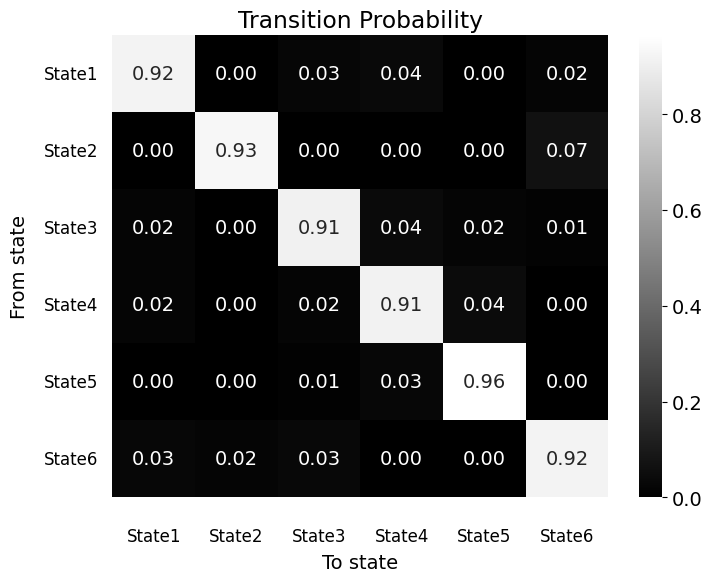

In [176]:


sequence_length = len(labels_list[4])
labels =np.array(labels_list[4])

# Count transitions between each pair of labels
transition_counts = np.zeros((6, 6), dtype=int)  # 6 labels in total
for i in range(1, len(labels)):
    from_label = labels[i - 1]
    to_label = labels[i]
    transition_counts[from_label][to_label] += 1

# Calculate transition probabilities
transition_probabilities = np.zeros((6, 6))
for i in range(6):
    row_sum = np.sum(transition_counts[i])
    if row_sum > 0:
        transition_probabilities[i] = transition_counts[i] / row_sum

plt.figure(figsize=(8, 6))
sns.heatmap(transition_probabilities, annot=True, cmap="gray", fmt=".2f", cbar=True)

plt.title('Transition Probability')
plt.xlabel('To state', labelpad=40)
plt.ylabel('From state', labelpad=60)
for i in range(6):
    plt.text(-0.5, i + 0.5, f'State{i+1}', ha='center', va='center', fontsize=12)
    plt.text(i + 0.5, 6.5, f'State{i+1}', ha='center', va='center', fontsize=12)
plt.xticks([])
plt.yticks([])

plt.show()